Windkessel Python Module
========================


For full documentation see:
https://ts-cubed.github.io/roam/20210322092917-windkessel_python_module.html


## Using the module



To use this, put the module somewhere in your `PYTHONPATH` or in the same directory as the calling code and import it using:

    import windkessel as wk

Then the windkessel solver can be called with:

    pressure = wk.solveWK(I, R1, R2, C, L)

Where `I` is a function object describing the volume flow waveform at the inlet of the windkessel as a function of time `t`.

This inlet waveform can be given in arbitrary units, but the other parameters need to be consistent, and the output will be in a unit that relates to input and parameter units. Typical units for the inlet volume flow are:

-   pysiological: $[\mathrm{ml\ s^{-1}}]$
-   SI units: $[\mathrm{m^3\ s^{-1}}]$

Parameters are:

-   `R1`, `R2`: proximal and distal resistances in either $[\mathrm{mm_{Hg}\ ml^{-1}\ s}]$ or $[\mathrm{Pa\ s\ m^{-3}}]$.
-   `C`: compliance in either $[\mathrm{ml\ mm_{Hg}^{-1}}]$ or $[\mathrm{m^{3}\ Pa^{-1}}]$.
-   `L`: total arterial inertance in either $[\mathrm{mm_{Hg}\ s^{2}\ ml^{-1}}]$ or $[\mathrm{Pa\ s^{2}\ m^{-3}}]$.

The output of the windkessel model will be a 1-dimensional `ndarray` with two pressures (assuming the result of `wk.solve_WK` has been written into `pressure` as above):

-   `pressure.y[0]`: the pressure at the inlet of the windkessel
-   `pressure.y[1]`: the pressure after the proximal resistance for 3 and 4 element windkessel models

The pressure that is calculated by the windkessel will be in either $[\mathrm{mm_{Hg}}]$, or $[\mathrm{Pa}]$, depending on the units of input and the parameters.

*Note that parameters found in literature are mostly in the physiological system, while the CFD code `haemoFoam` will require parameters in SI units!*



### Importing all the necessary modules



Copy `windkessel.py` into your `PYTHONPATH` or into the working directory of your project. Then import the module as usual (I use the shorthand `wk`):



In [2]:
import windkessel as wk

We will also need `numpy` and `matplotlib.pyplot` (I use the usual shorthand namespaces for the import here) <sup><a id="fnr.1" class="footref" href="#fn.1">1</a></sup>:


# Footnotes

<sup><a id="fn.1" href="#fnr.1">1</a></sup> Never use the `import * from` method, this will cause functions to be overwritten and makes for code that is terrible to read and impossible to debug


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Seaborn makes the plots look a bit more modern
import seaborn as sns

sns.set_theme()
sns.set(rc={"figure.dpi": 300, "savefig.dpi": 300})
sns.set_style("white")

### Setting the input waveform



The input waveform needs to be defined as a function object that returns a value for the volume flow rate as a function of the parameter time



#### Generic sine based waveform with dicrotic notch



In this example I use a generic waveform that is based on a sine wave with a period time $T$, a systolic time $T_{syst}$, and a dicrotic notch time of $T_{dicr}$. The maximum and minumum flow rates are given as $I_{max}$ and $I_{min}$.

-   This waveform is similar to the flow into the aorta, if $I_{min}$ is set to zero and a dicrotic notch time is used
-   It can also be used as a generic waveform for an artery further down the tree with $T_{dicr} = 0$ and a set $I_{min}$.

$$
f(x)=\begin{cases}
(I_{max} - I_{min}) \sin(\pi \frac{t^{\%}}{T_{syst}} ) + I_{min} &,  (t^{\%}) \leq (T_{syst}+T_{dicr})\\
I_{min} &,  (t^{\%}) > (T_{syst}+T_{dicr})
\end{cases}
$$

where $t^{\%}$ is $t$ `modulo` $T$, i.e. the time in the current period, $0 \leq t^{\%} < 1$.

Setting the waveform parameters:



In [4]:
# Generic Input Waveform
# max volume flow in ml/s
max_i = 425

# min volume flow in m^3/s
min_i = 0.0

# Period time in s
T = 0.9

# Syst. Time in s
systTime = 2 / 5 * T

# Dicrotic notch time
dicrTime = 0.0

Define the waveform as a function.

*Note: I use a Boolean condition to implement the piecewise function!*



In [5]:
def I_generic(t):
    # implicit conditional using boolean multiplicator
    # sine waveform
    I = (
        (max_i - min_i) * np.sin(np.pi / systTime * (t % T))
        * (t % T < (systTime + dicrTime) )
        + min_i
    )

    return I

So let&rsquo;s have a look at the waveforms:

*Note: I am already calling the `ddt` and `d2dt` functions from the `windkessel` module. They are prefixed with their namespace `wk`.*

*Note 2: The `d2dt` function as it is implemented (central difference) is not defined at the beginning of the time range. So autoscale will not work and give you a flat line on a huge y-axis scale!*



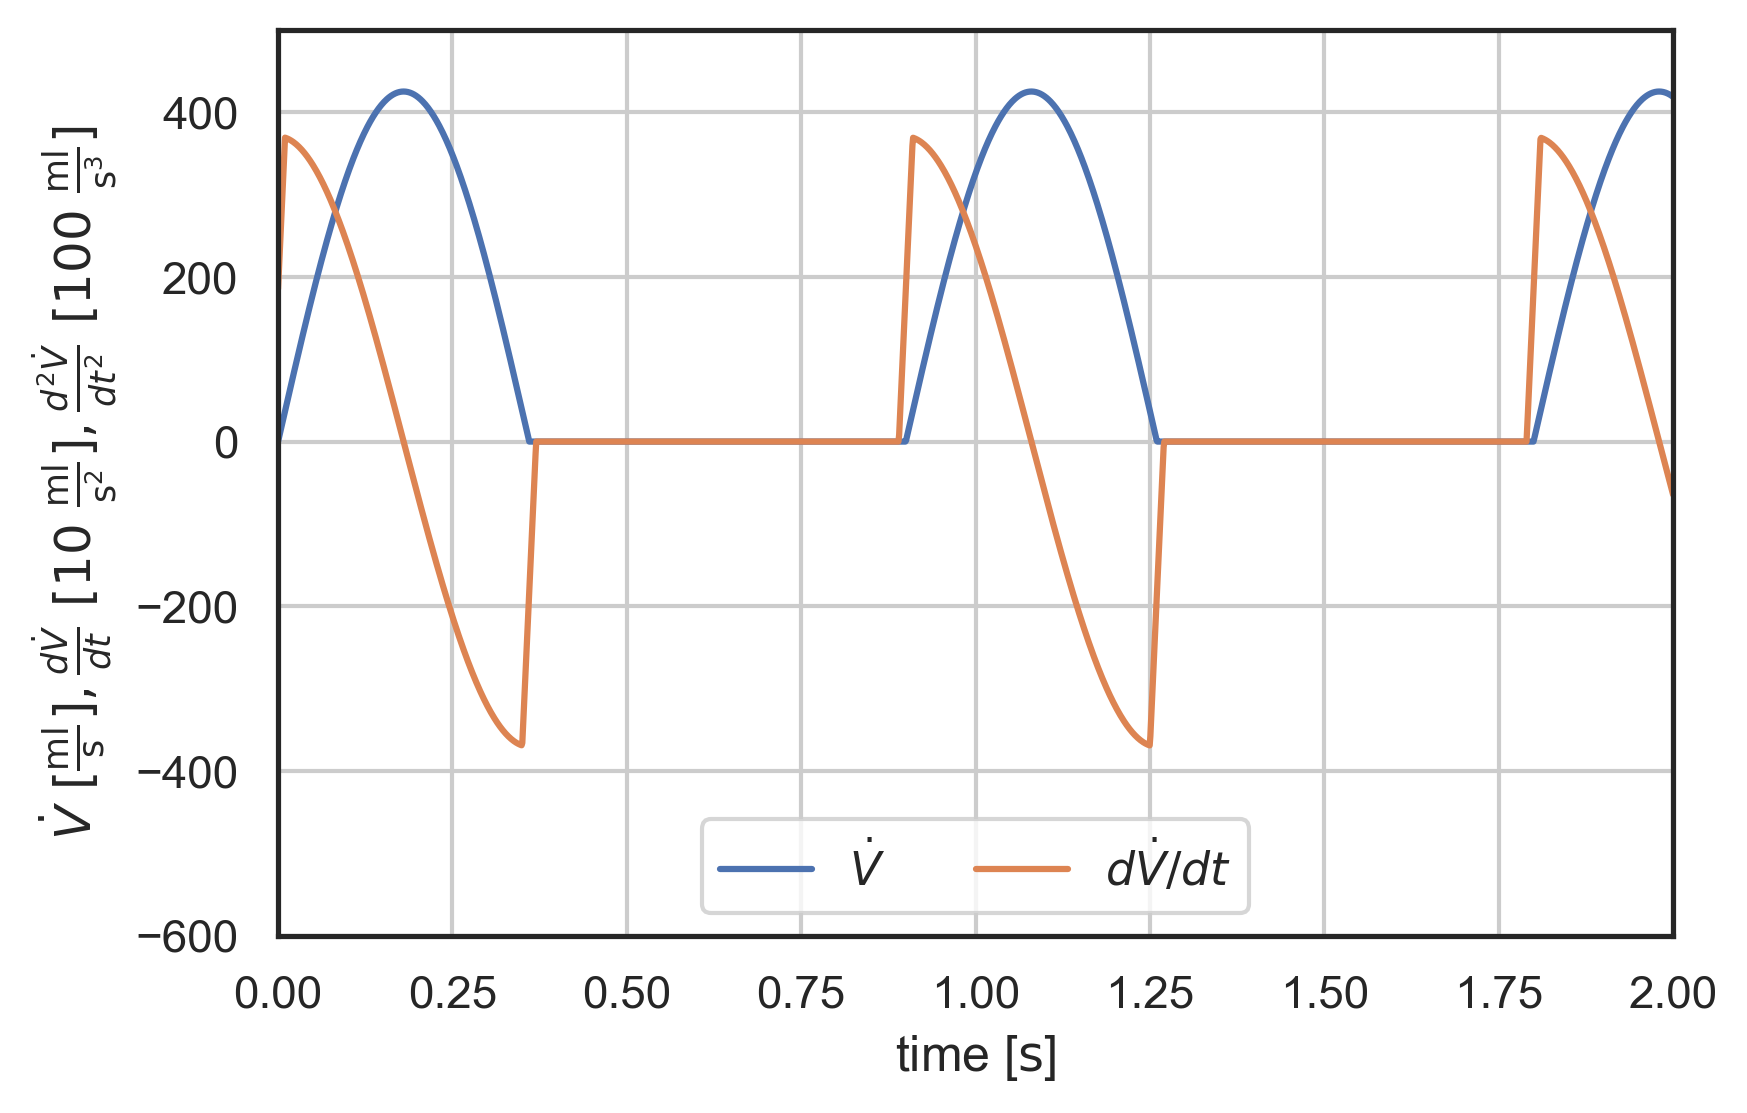

In [6]:
t = np.linspace(0, 2, 2000)

plt.plot(t, I_generic(t), label="$\dot{V}$")
plt.plot(t, 0.1 * wk.ddt(I_generic, t, 0.01), label="$d\dot{V}/dt$")
# plt.plot(t, 0.01 * wk.d2dt2(I_generic, t, 0.0001), label="$d^{2}\dot{V}/dt^{2}$")
plt.xlabel("time [$\\mathrm{s}$]")
plt.ylabel(
    "$\dot{V}\ [\mathrm{\\frac{ml}{s}}],\
    \\frac{d\dot{V}}{dt}\ [10\ \mathrm{\\frac{ml}{s^{2}}}],\
    \\frac{d^{2}\dot{V}}{dt^{2}}\ [100\  \mathrm{\\frac{ml}{s^{3}}}]$"
)
plt.xlim(0, 2)
plt.ylim(-600, 500)
plt.grid()
plt.legend(loc="lower center", ncol=3)

### Solving the windkessel equations



The solution of the windkessel equations is then done using a simple command `wk.solve_wk`. The distinction between 2-element, 3-element, or 4-element windkessel models is done via selection of the model parameters `Rc`, `Rp`, `C`, and `L`. All parameters must be given, `Rc` and `L` can be set to `0.0` to eliminate the element from the model.

*Note: `Rp` and `C` must not be set to zero, which would result in a division by zero.*

*Note 2: If `C` is set to a very low value the windkessel model may not finish successfully.*



In [7]:
# Set parameters for 3-Element Windkessel Model
R1 = 0.01
R2 = 1
C = 2.0
L = 0.0

time_start = 0
time_end = 30
N = (time_end - time_start) * 1000

pressure = wk.solve_wk(I_generic, R1, R2, C, L, time_start, time_end, N, "RK45", [0, 0] ,1e-9)

# Note: all other parameters to wk.solve_wk are optional
#       if they are not given, defaults will be used
#       Here I use time range from 0 to 30 and 30000 steps
#       to override the default of 0, 10, 10000

And plot the result:



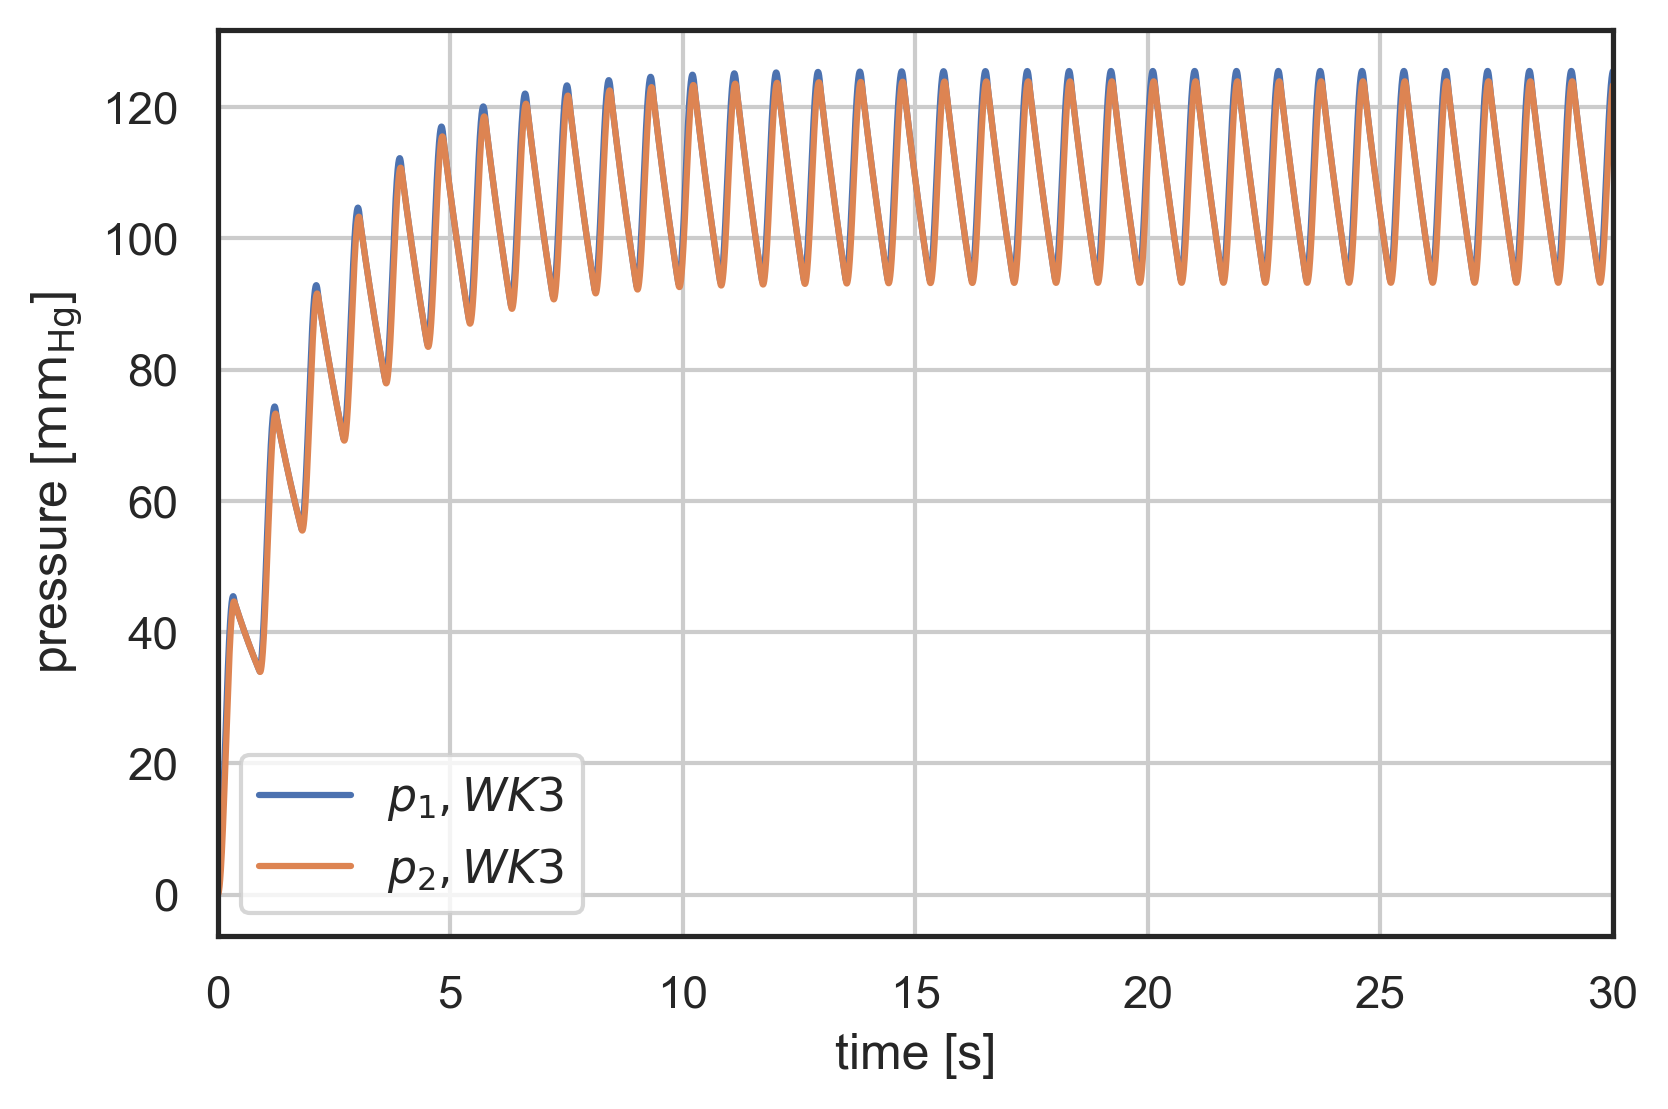

In [8]:
# the solution is returned as an array with labels 't' and 'y'
# where 'y' is a vector array with two entries
# y[0] - pressure before R1
# y[1] - pressure after R2

# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")
plt.xlim(0, 30)

# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure.t, pressure.y[0], label="$p_1, WK3$")
plt.plot(pressure.t, pressure.y[1], label="$p_2, WK3$")
plt.legend()
plt.grid()

Let&rsquo;s have a closer look at the last 10% of that plot:



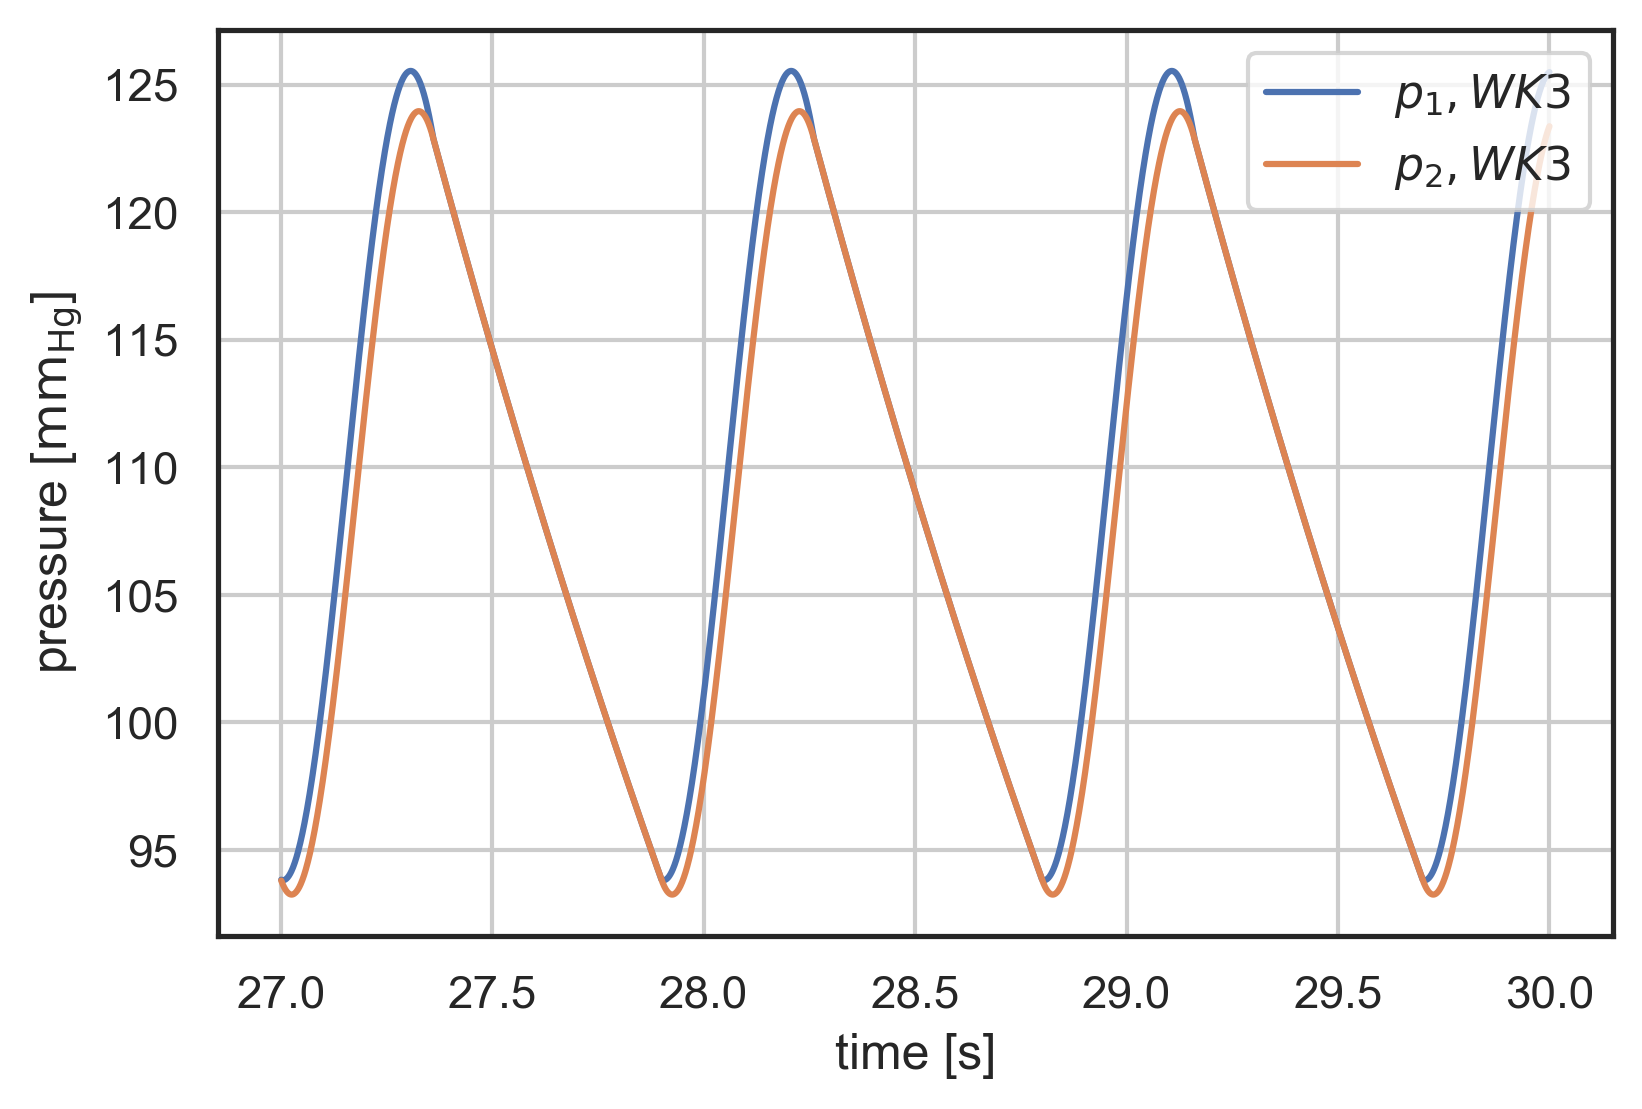

In [9]:
# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")

startN = int(0.9 * N)
# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure.t[startN:], pressure.y[0][startN:], label="$p_1, WK3$")
plt.plot(pressure.t[startN:], pressure.y[1][startN:], label="$p_2, WK3$")
# plt.plot(
#     pressure.t[startN:],
#     pressure.y[0][startN:]
#     - R1 * I_generic(pressure.t[startN:])
#     - L * wk.ddt(I_generic, pressure.t[startN:]),
#     label="p_2 analytical",
# )
plt.legend()
plt.grid()

### Pedrizzetti waveform <sup id="f1b67dce4c47a8429d4b989a532a5011"><a href="#Pedrizzetti1996" title="Pedrizzetti, Unsteady Tube Flow over an Expansion, {Journal of Fluid Mechanics}, v(), 89--111 (1996).">Pedrizzetti1996</a></sup>



In [10]:
# Parameters
C0 = 0.4355
C2 = 0.05
C4 = -0.13
C6 = -0.1
C8 = -0.01

S2 = 0.25
S4 = 0.13
S6 = -0.02
S8 = -0.03

# Area of the CCA
# area = 3e-5
area = 400


def I_ped(t):
    return (
        C0
        + C2 * np.cos(2 * np.pi * t)
        + S2 * np.sin(2 * np.pi * t)
        + C4 * np.cos(4 * np.pi * t)
        + S4 * np.sin(4 * np.pi * t)
        + C6 * np.cos(6 * np.pi * t)
        + S6 * np.sin(6 * np.pi * t)
        + C8 * np.cos(8 * np.pi * t)
        + S8 * np.sin(8 * np.pi * t)
    ) * area

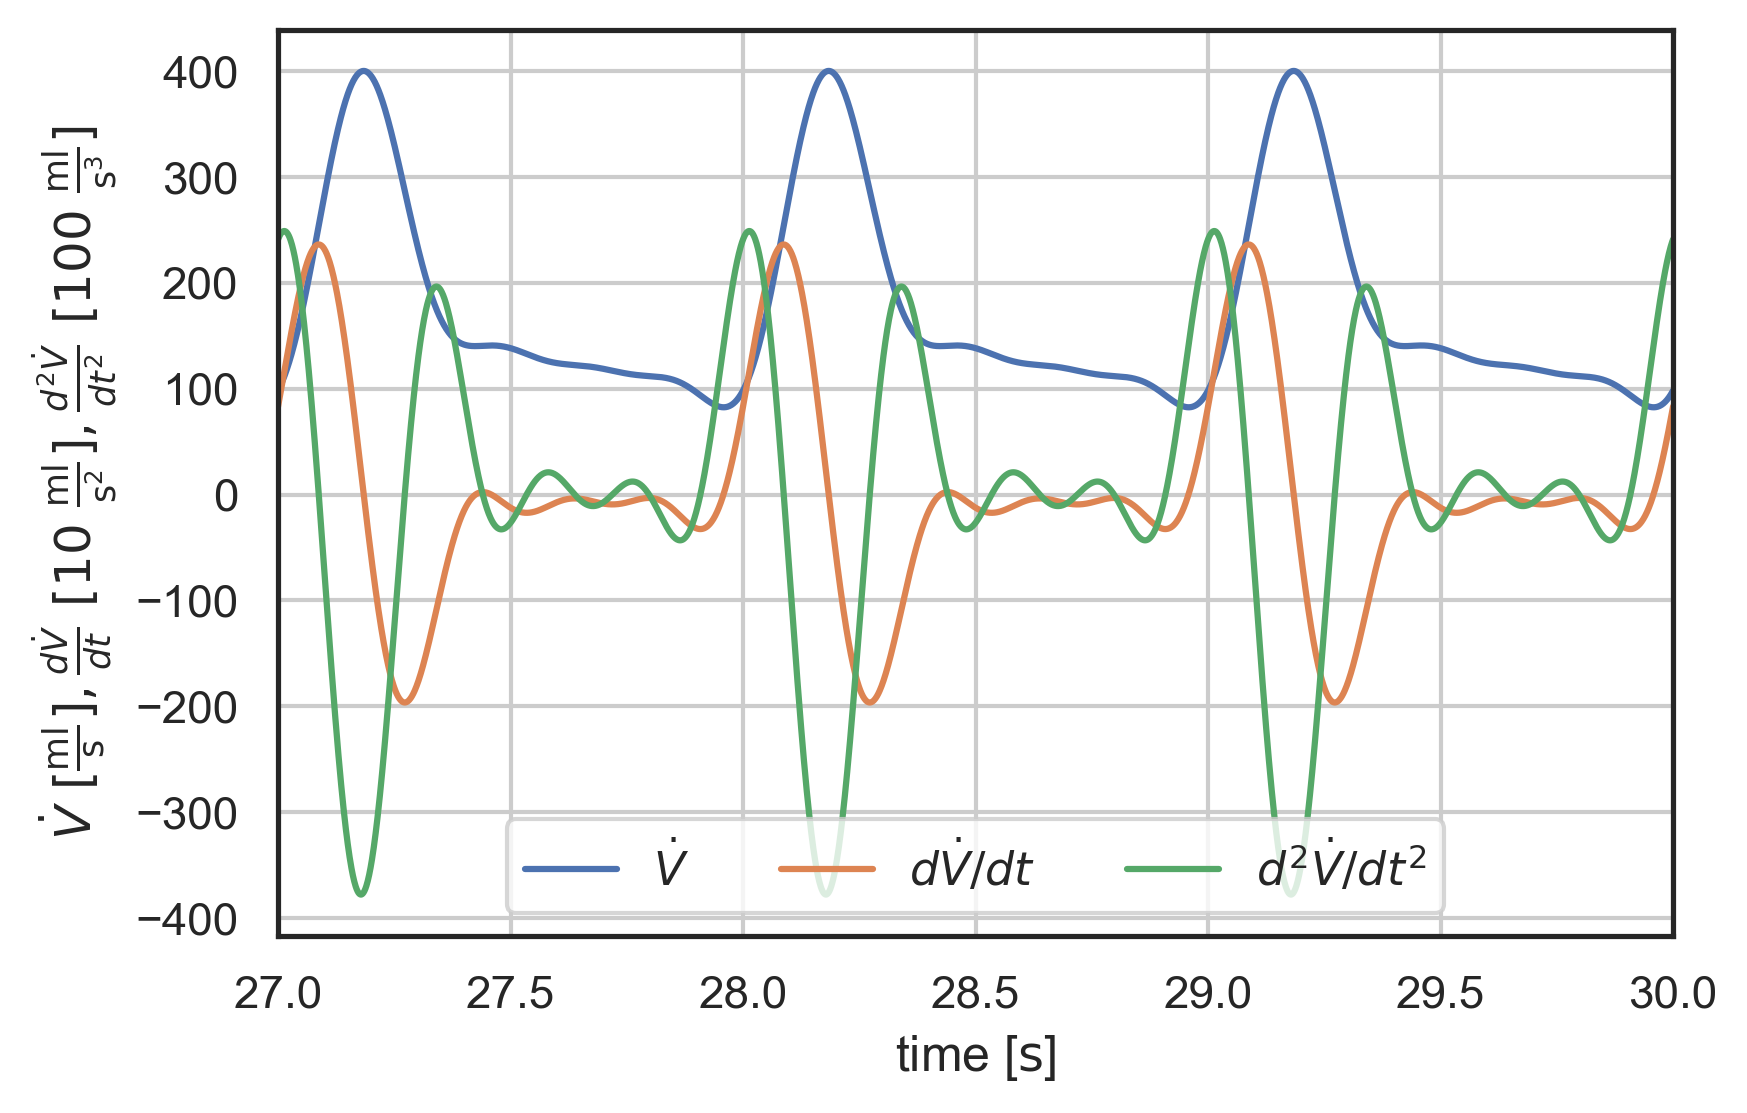

In [11]:
t = np.linspace(0, 30, 30000)

plt.plot(t, I_ped(t), label="$\dot{V}$")
plt.plot(t, 0.1 * wk.ddt(I_ped, t, 1e-2), label="$d\dot{V}/dt$")
plt.plot(t, 0.01 * wk.d2dt2(I_ped, t, 1e-2), label="$d^{2}\dot{V}/dt^{2}$")
plt.xlabel("time [$\\mathrm{s}$]")
plt.ylabel(
    "$\dot{V}\ [\mathrm{\\frac{ml}{s}}],\
    \\frac{d\dot{V}}{dt}\ [10\ \mathrm{\\frac{ml}{s^{2}}}],\
    \\frac{d^{2}\dot{V}}{dt^{2}}\ [100\  \mathrm{\\frac{ml}{s^{3}}}]$"
)
plt.xlim(27, 30)
# plt.ylim(-600, 500)
plt.grid()
plt.legend(loc="lower center", ncol=3)

In [12]:
# Set parameters for Windkessel Model
Rc = 0.033
Rp = 0.6
C = 1.25
# L for serial model - pure serial will use 1/10 of this!
Ls = 0.02
# L for parallel
Lp = 0.02

time_start = 0
time_end = 30
N = (time_end - time_start) * 1000

fun = I_ped

In [13]:
pressure2wk = wk.solve_wk(
    fun=fun,
    Rc=0,
    Rp=Rp,
    C=C,
    L=0,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

pressure3wk = wk.solve_wk(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=0,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

pressure4wks = wk.solve_wk(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=Ls / 10,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)


pressure4wkp = wk.solve_wk4p(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=Lp,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0, 0],
    rtol=1e-9,
)

# Note: all other parameters to wk.solve_wk are optional
#       if they are not given, defaults will be used
#       Here I use time range from 0 to 30 and 30000 steps
#       to override the default of 0, 10, 10000

In [14]:
pressure5wk = wk.solve_wk5(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    Ls=Ls,
    Lp=Lp,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

And plot the result:



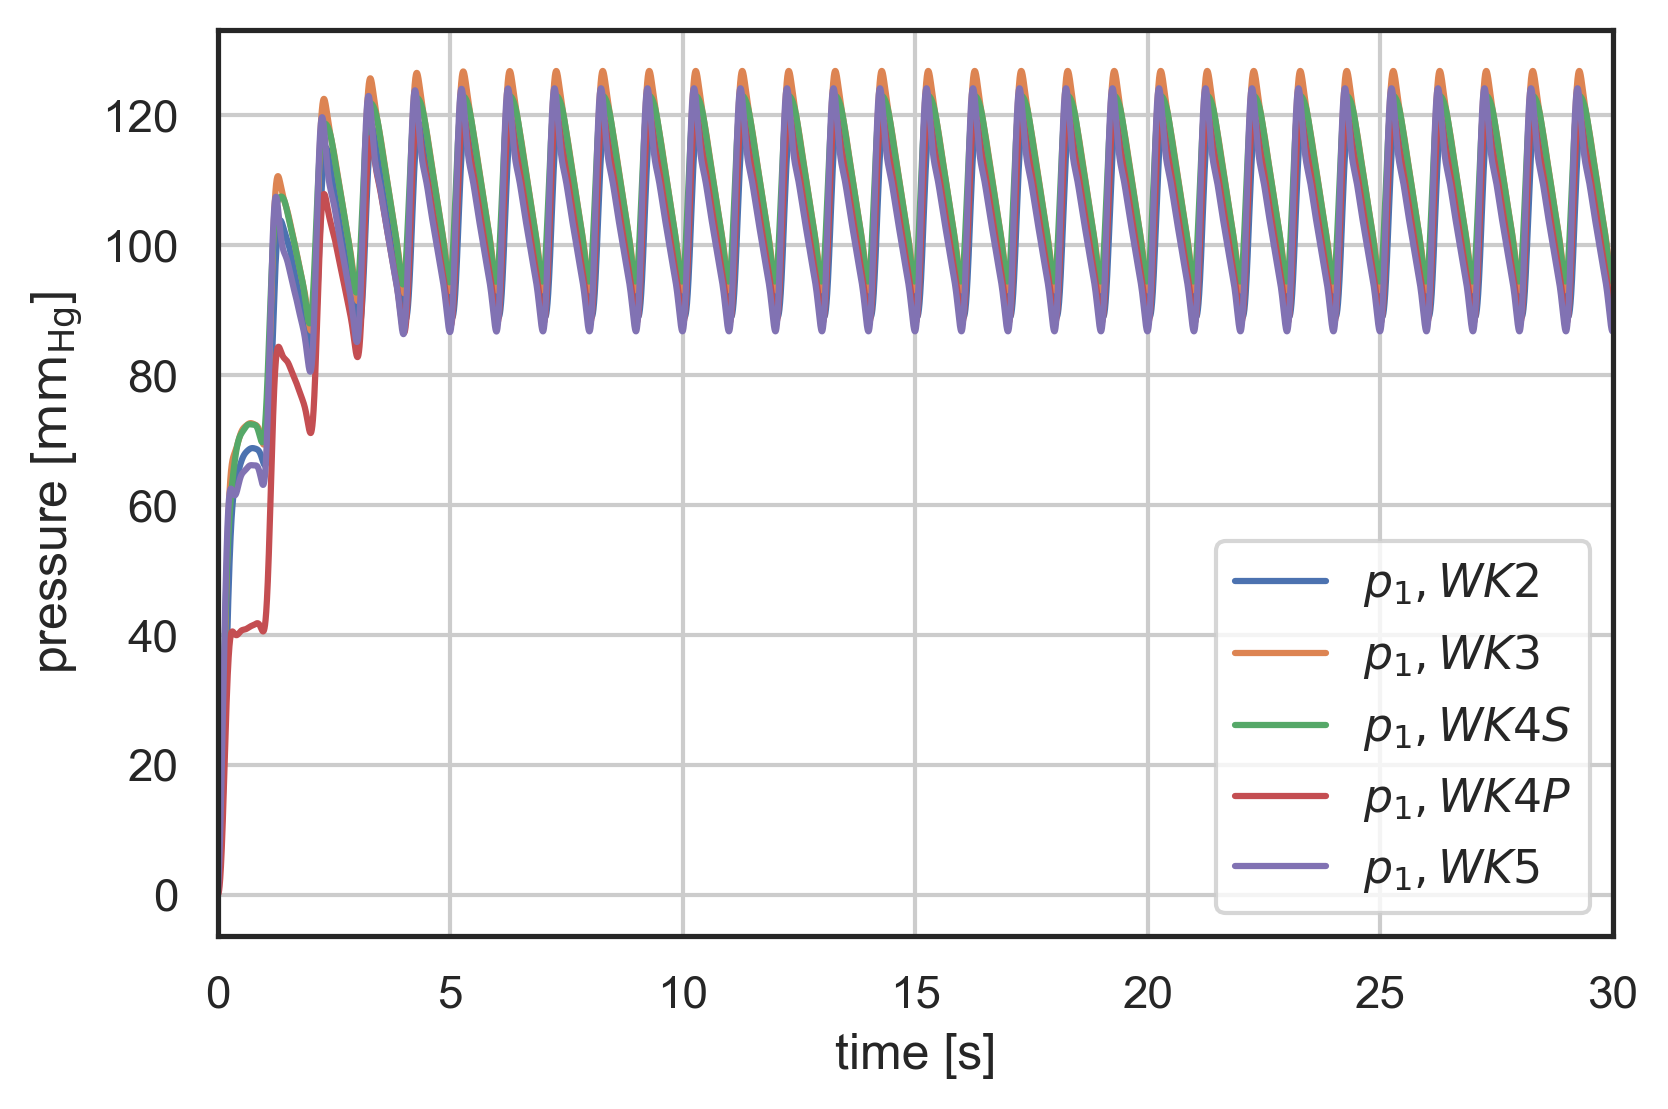

In [15]:
# the solution is returned as an array with labels 't' and 'y'
# where 'y' is a vector array with two entries
# y[0] - pressure before R1
# y[1] - pressure after R2

# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")
plt.xlim(0, 30)

# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure2wk.t, pressure2wk.y[0], label="$p_1, WK2$")
plt.plot(pressure3wk.t, pressure3wk.y[0], label="$p_1, WK3$")
plt.plot(pressure4wks.t, pressure4wks.y[0], label="$p_1, WK4S$")
plt.plot(pressure4wkp.t, pressure4wkp.y[0], label="$p_1, WK4P$")
plt.plot(pressure5wk.t, pressure5wk.y[0], label="$p_1, WK5$")
# plt.plot(pressure.t, pressure.y[1], label="$p_2, WK4S$")
plt.legend()
plt.grid()

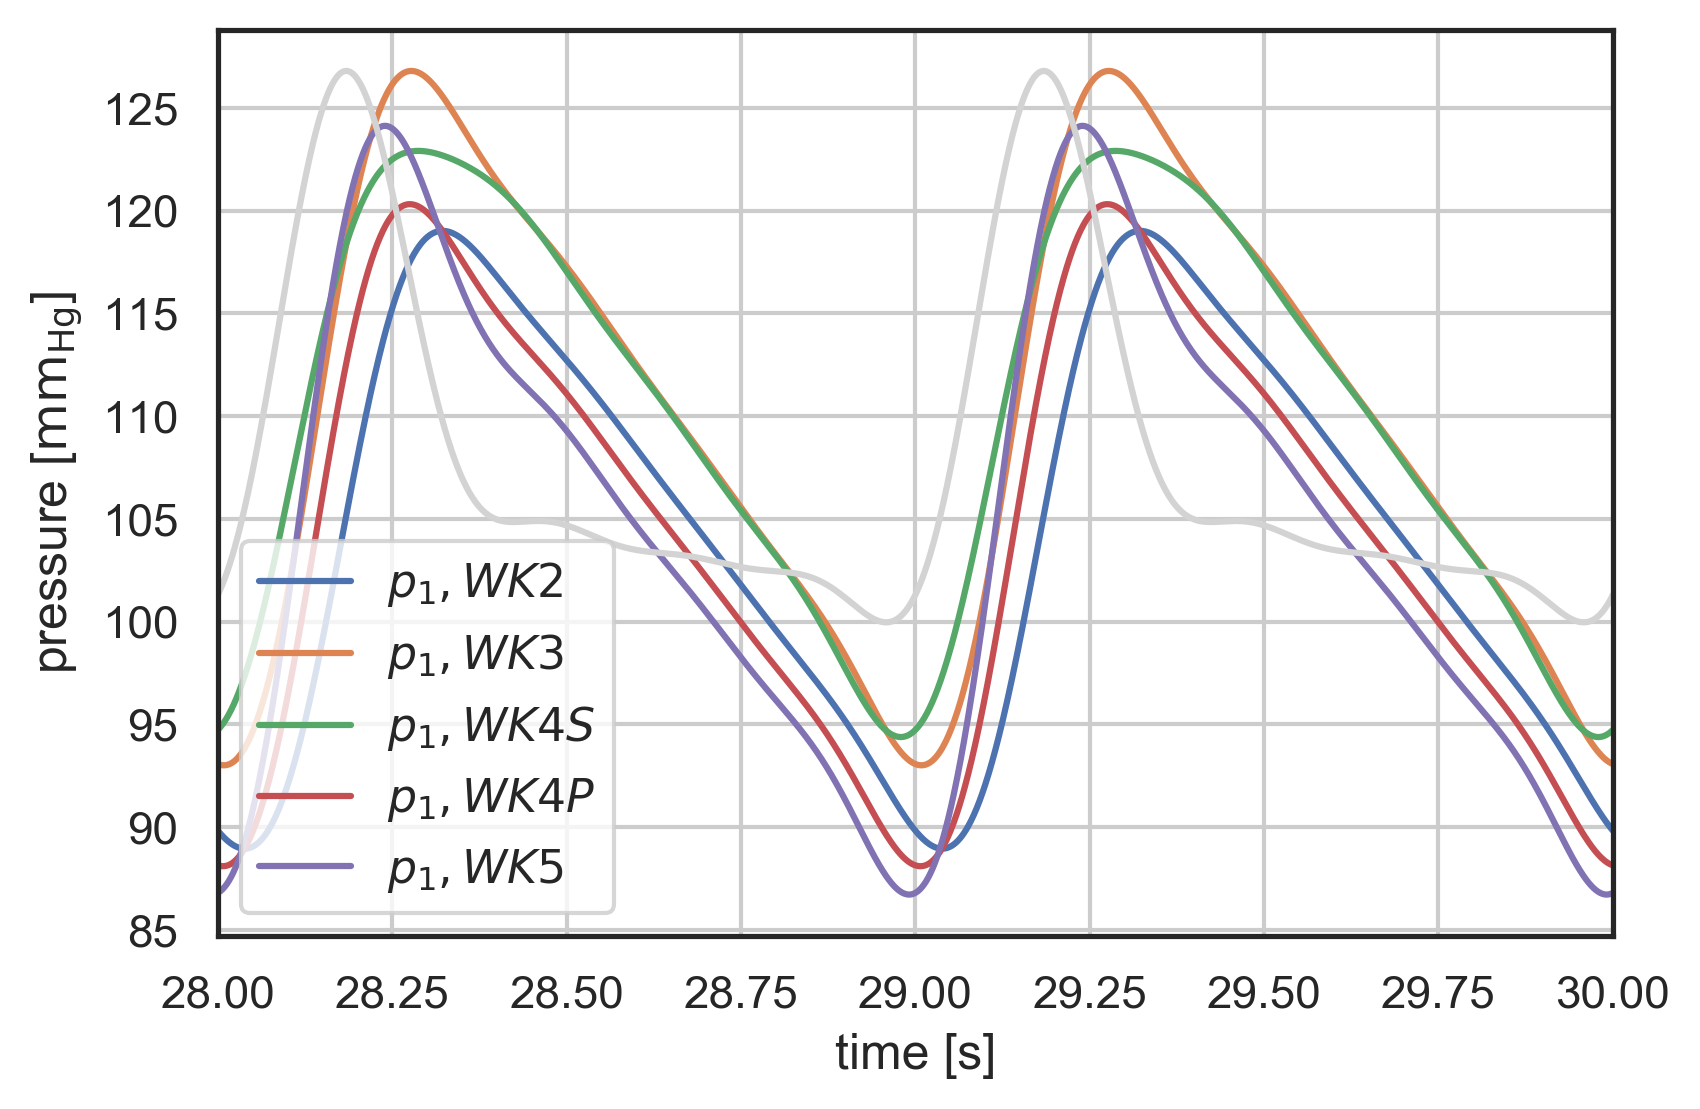

In [16]:
# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")

startN = int(0.9 * N)
# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure2wk.t[startN:], pressure2wk.y[0][startN:], label="$p_1, WK2$")
plt.plot(pressure3wk.t[startN:], pressure3wk.y[0][startN:], label="$p_1, WK3$")
plt.plot(pressure4wks.t[startN:], pressure4wks.y[0][startN:], label="$p_1, WK4S$")
plt.plot(pressure4wkp.t[startN:], pressure4wkp.y[0][startN:], label="$p_1, WK4P$")
plt.plot(pressure5wk.t[startN:], pressure5wk.y[0][startN:], label="$p_1, WK5$")


# Plot the inlet waveform in lightgrey scaled to fit
t = np.linspace(28, 30, 2000)

scaledQ = (
    (I_ped(t) / np.max(I_ped(t))
    * (np.max(pressure3wk.y[0]) - np.min(pressure3wk.y[0][startN:]))
    + np.min(pressure3wk.y[0][startN:]))
)


plt.plot(t, scaledQ, color="lightgrey")

plt.xlim(28, 30)
plt.legend()
plt.grid()

### Working with high temporal resolution volume flow data



If the volume flow data is measured with a high temporal resolution, the volume flow at any time can be obtained from

-   interpolation: `scipy` has many interpolation methods available. Most are unsuited to our case for two reasons:
    -   They are not second-order differentiable. The windkessel model is using the second time derivative of `I`. If the inlet waveform has jerks (2nd derivative discontinuities), then this can lead to numerical instabilities or non-physical results. While, e.g. Akima, or Pchip reproduce most measured waveforms very well, they are only first order differentiable.
    -   They are unbounded. Higher order interpolations, e.g. cubic splines, are second order differentiable, but can lead to unbounded oscillations, in particular for cases that show high frequency effects, e.g., dicrotic notch.

-   Fourier Transforms: FFT and IFFT are a good way to transform a discrete dataset into a continuous function that can be used for the windkessel model. However they require a high sampling rate to avoid oscillations (similar to higher order interpolations) and follow the original waveform closely.



#### FFT/IFFT implementation



### Working with low temporal resolution scanned volume flow data



In many cases the velocity is going to be measured using Echo-Doppler and needs to be scanned from the Echo images or is otherwise only available in a low time resolution. In this case we need to create a high time-resolution waveform from the low resolution data.

Interpolation leads to unbounded oscillations in this case, so we use a third order B-Spline approximation that will give a smooth second order differential.

*Note: Since the B-Spline is bounded it will always stay on the concave side of the scanned data, i.e. bounded, but will not go through the measured points. The deviation is typically within the measurement uncertainty if the measurement is digitised with this in mind.*

This method was developed for smooth 3-d B-Splines for 2nd order smooth prescribed movement of the ventricular wall and is described in  <sup id="153d7f73c50355df0f6f71414bbd0032"><a href="#Schenkel2009" title="Schenkel, Malve, Reik, Markl, Jung \&amp; Oertel, {{MRI}}-Based {{CFD}} Analysis of Flow in a Human Left Ventricle: Methodology and Application to a Healthy Heart., {Annals of Biomedical Engineering}, v(3), 503--515 (2009).">Schenkel2009</a></sup>.

Let&rsquo;s test this using this rough waveform of an aortic flow, scanned from an Echo-Doppler printout. `vol` is a `(2,15)` array, where `vol[0]` is the time, and `vol[1]` the volume flow rate array.



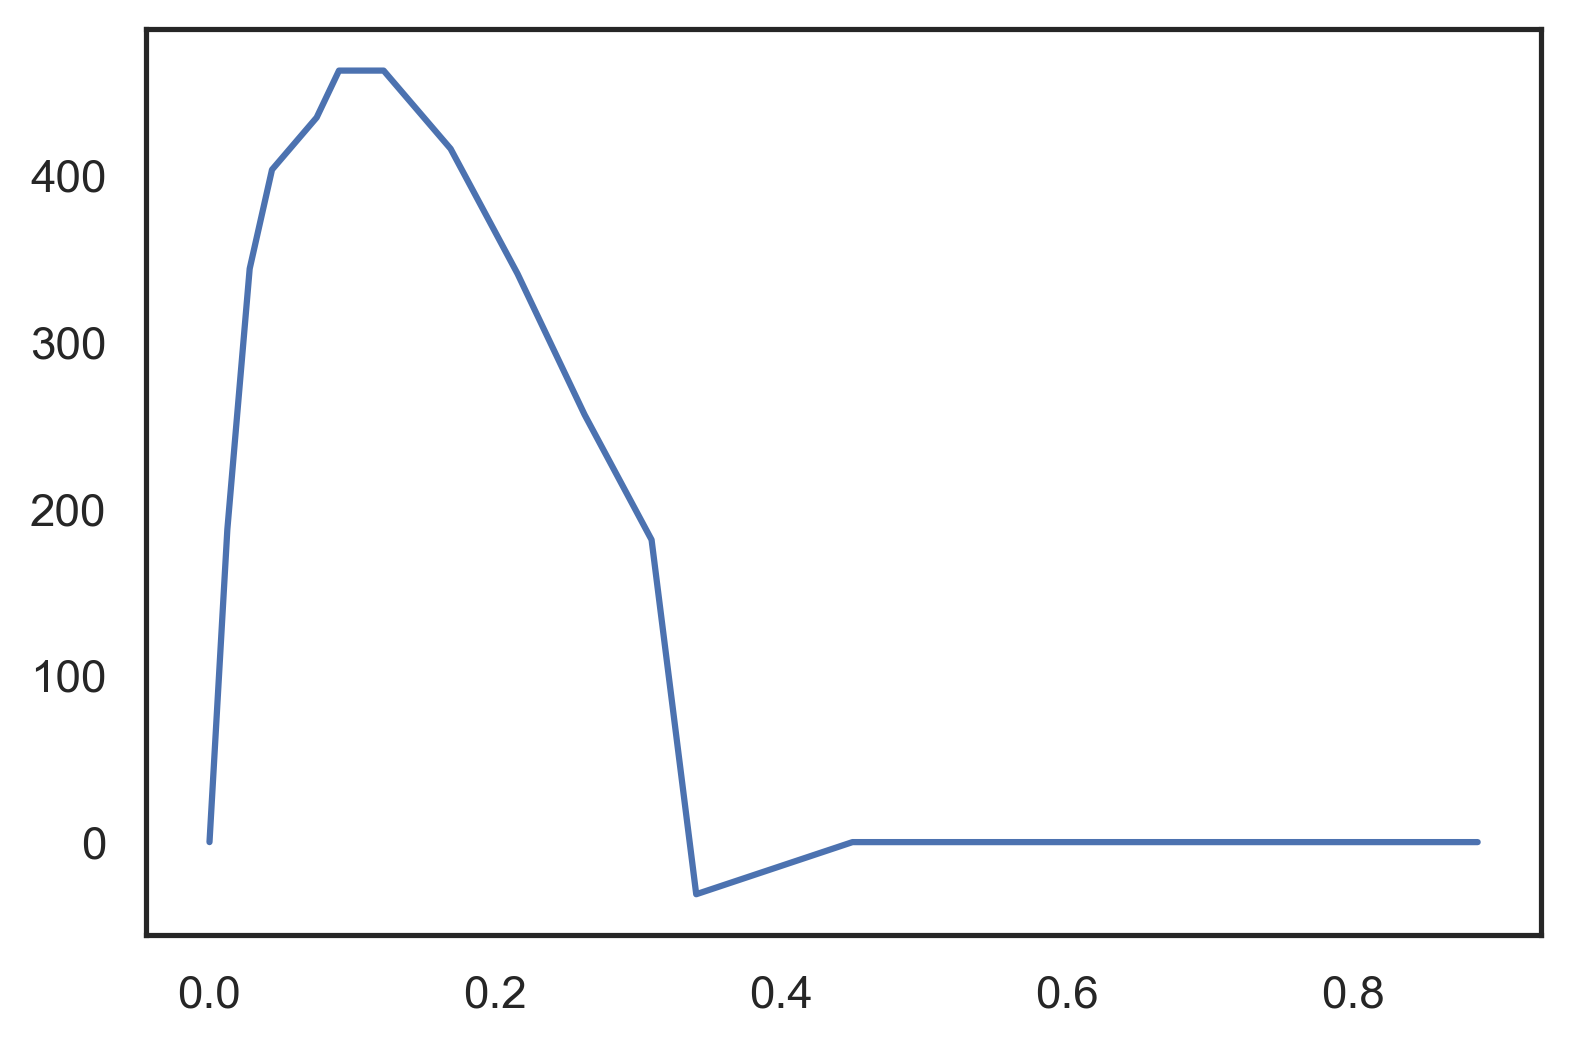

In [17]:
vol = np.zeros((2, 15))

vol[0] = [0., 0.0125, 0.028125, 0.04375, 0.075, 0.090625, 0.121875, 0.16875, 0.215625, 0.2625, 0.309375, 0.340625, 0.45, 0.66875, 0.8875]
vol[1] = [0., 187.52, 343.76, 403.12, 434.4, 462.52, 462.52, 415.64, 340.64, 256.24, 181.24, -31.25, 0., 0., 0.]

plt.plot(vol[0], vol[1])

The approximated waveform function can be defined using `wk.PWBezier`:



In [18]:
def I_Bezier(t):
    return wk.PWBezier(vol, t)

As we can show the approximated waveform follows the scanned waveform, but stays on the concave side and is bounded without any oscillations. It can be seen that the dicrotic notch is underrepresented. This shows that the resolution needs to be increased around that point.

*Note: When digitising curves, make sure you include two points either side of a detail like this. These two points will define how far the approximation will be pulled into the notch.*



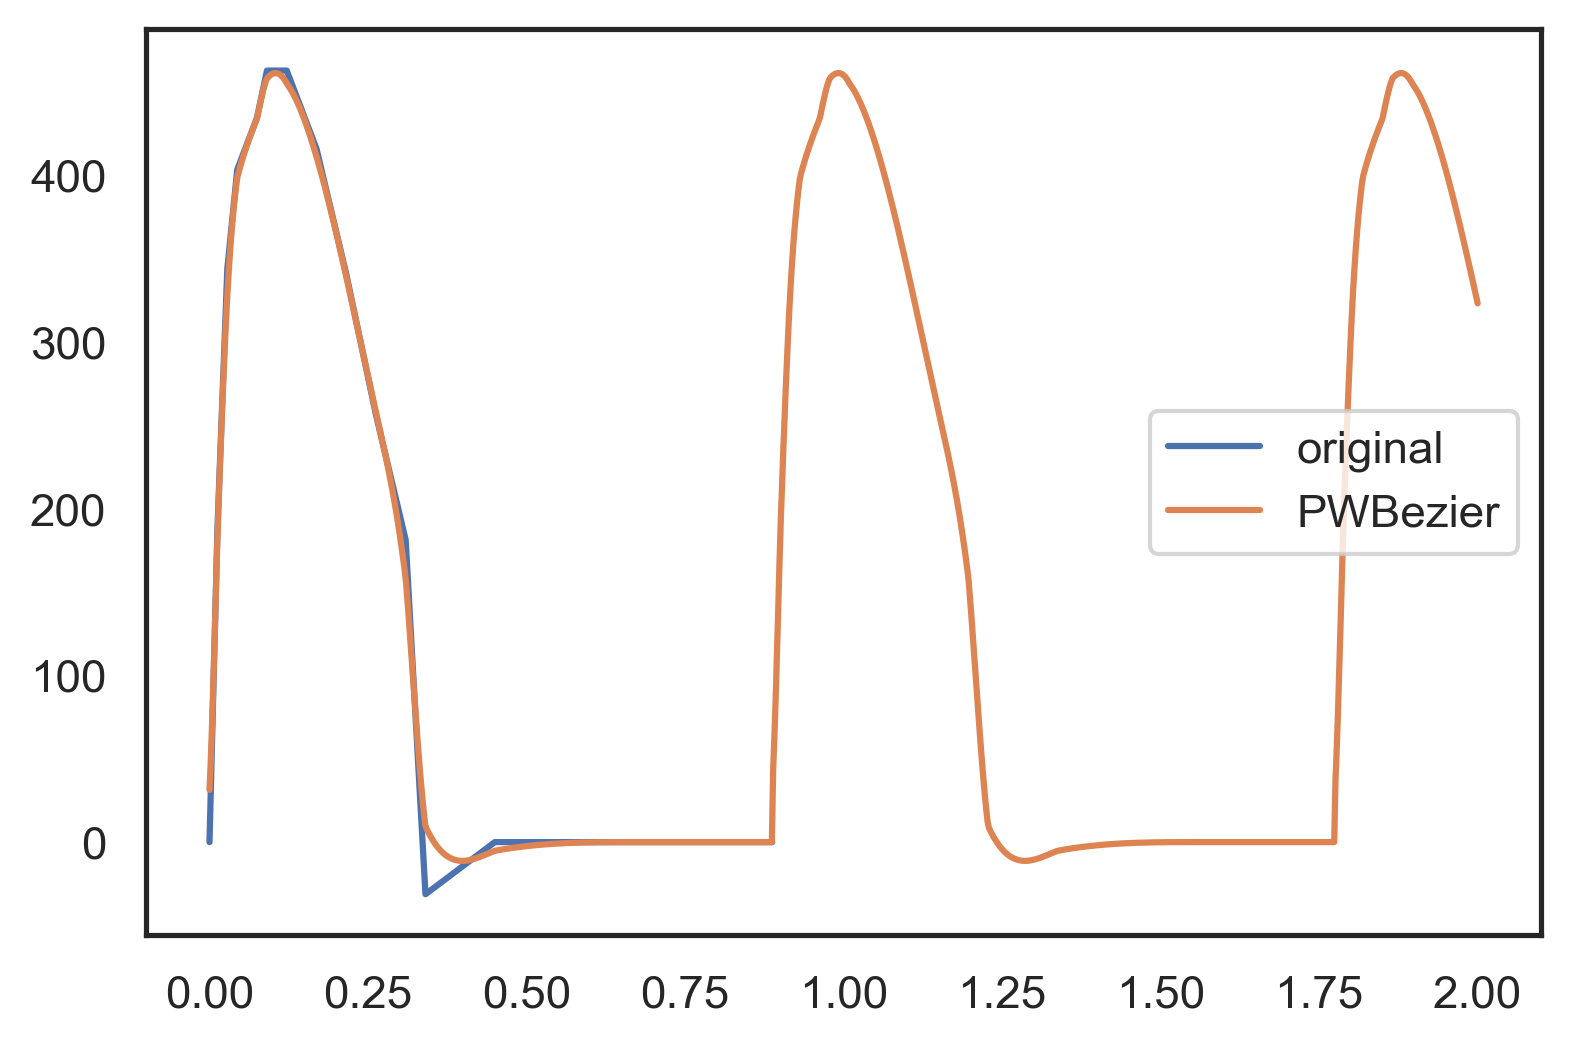

In [19]:
ta = np.linspace(0, 2, 1000)
        
plt.plot(vol[0], vol[1], label='original')
plt.plot(ta, I_Bezier(ta), label='PWBezier')
plt.legend()

In [20]:
# Set parameters for Windkessel Model
Rc = 0.03
Rp = 0.8
C = 2
# L for serial model - pure serial will use 1/10 of this!
Ls = 0.0
# L for parallel
Lp = 0.02

time_start = 0
time_end = 30
N = (time_end - time_start) * 1000

fun = I_Bezier

In [21]:
pressure2wk = wk.solve_wk(
    fun=fun,
    Rc=0,
    Rp=Rp,
    C=C,
    L=0,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

pressure3wk = wk.solve_wk(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=0,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

pressure4wks = wk.solve_wk(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=Ls/10,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)


pressure4wkp = wk.solve_wk4p(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=Lp,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0, 0],
    rtol=1e-9,
)

# Note: all other parameters to wk.solve_wk are optional
#       if they are not given, defaults will be used
#       Here I use time range from 0 to 30 and 30000 steps
#       to override the default of 0, 10, 10000

In [22]:
pressure5wk = wk.solve_wk5(
    fun=fun,
    Rc=Rc,
    Rp=Rp,
    C=C,
    Ls=Ls,
    Lp=Lp,
    time_start=0,
    time_end=30,
    N=30000,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

And plot the result:



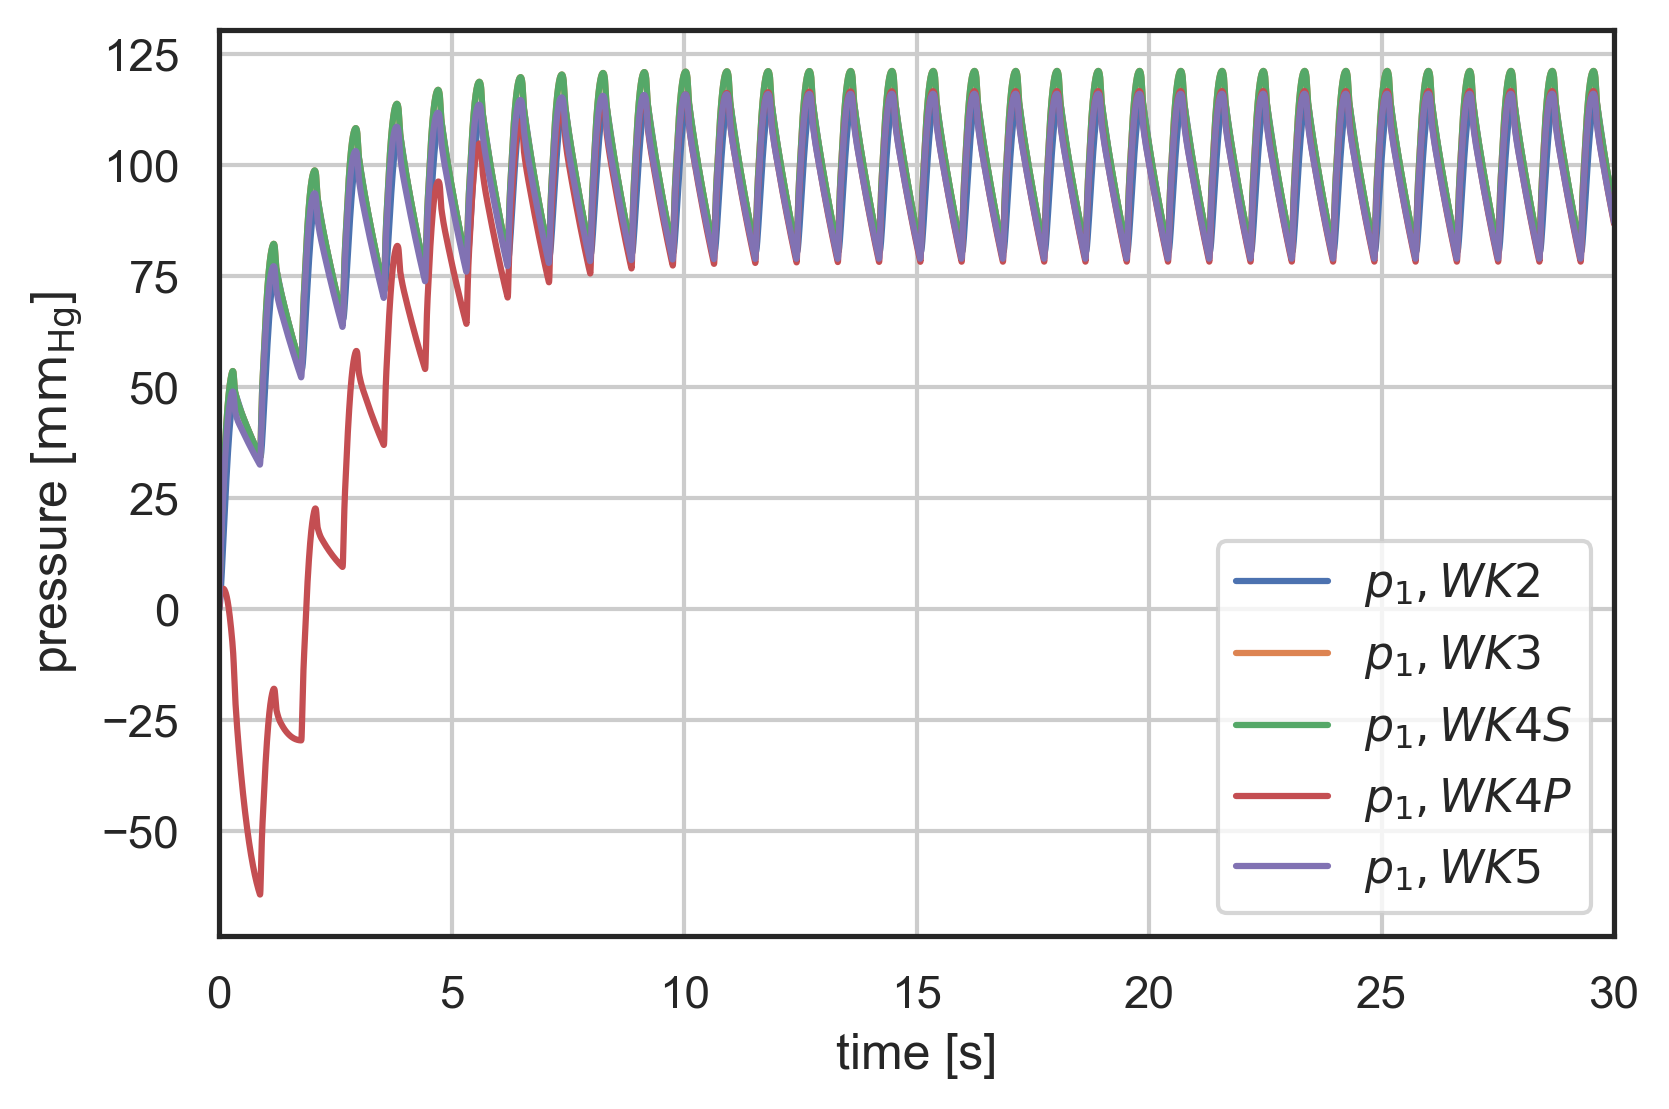

In [23]:
# the solution is returned as an array with labels 't' and 'y'
# where 'y' is a vector array with two entries
# y[0] - pressure before R1
# y[1] - pressure after R2

# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")
plt.xlim(0, 30)

# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure2wk.t, pressure2wk.y[0], label="$p_1, WK2$")
plt.plot(pressure3wk.t, pressure3wk.y[0], label="$p_1, WK3$")
plt.plot(pressure4wks.t, pressure4wks.y[0], label="$p_1, WK4S$")
plt.plot(pressure4wkp.t, pressure4wkp.y[0], label="$p_1, WK4P$")
plt.plot(pressure5wk.t, pressure5wk.y[0], label="$p_1, WK5$")
# plt.plot(pressure.t, pressure.y[1], label="$p_2, WK4S$")
plt.legend()
plt.grid()

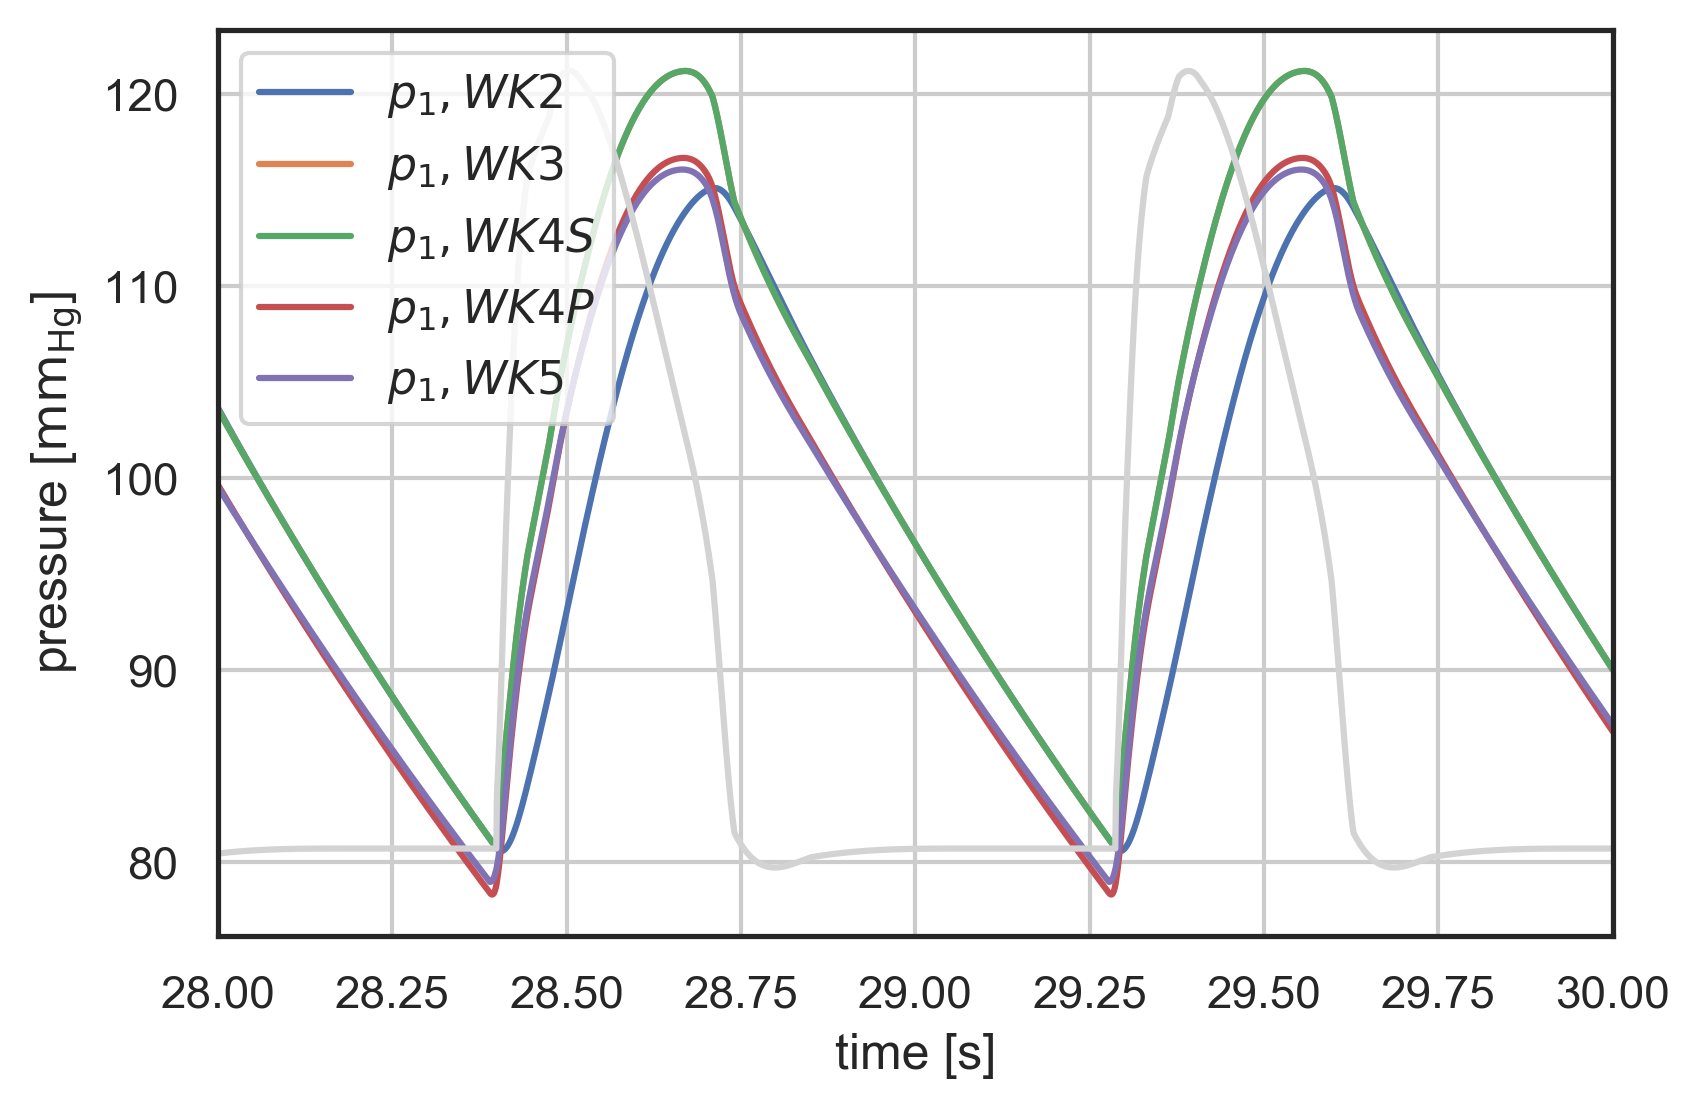

In [24]:
# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")

startN = int(0.9 * N)
# plot first and second component (index 0, 1) of array 'y'
# over array 't':
plt.plot(pressure2wk.t[startN:], pressure2wk.y[0][startN:], label="$p_1, WK2$")
plt.plot(pressure3wk.t[startN:], pressure3wk.y[0][startN:], label="$p_1, WK3$")
plt.plot(pressure4wks.t[startN:], pressure4wks.y[0][startN:], label="$p_1, WK4S$")
plt.plot(pressure4wkp.t[startN:], pressure4wkp.y[0][startN:], label="$p_1, WK4P$")
plt.plot(pressure5wk.t[startN:], pressure5wk.y[0][startN:], label="$p_1, WK5$")
# plt.plot(
#     pressure.t[startN:],
#     pressure.y[0][startN:]
#     - R1 * I_generic(pressure.t[startN:])
#     - L * wk.ddt(I_generic, pressure.t[startN:]),
#     label="p_2 analytical",
# )

t = np.linspace(28, 30, 2000)
plt.plot(
    t,
    I_Bezier(t)
    / np.max(I_Bezier(t))
    * (np.max(pressure3wk.y[0]) - np.min(pressure3wk.y[0][startN:]))
    + np.min(pressure3wk.y[0][startN:]),
    color="lightgrey",
)


plt.xlim(28, 30)
plt.legend()
plt.grid()

*Note: As can be seen from this graph, the serial 4-element WK is very sensitive to the inertance. Since in the current implementation this depends on $\frac{d^{2}I}{dt^{2}}$ it seems sensible to modify that implementation in a similar fashion as the 5-element model.*

*Note 2: Presumably the deviation between `WK4P` and `WK5` has to do with the second flow derivative as well, and `WK5` is therefore the better representation.*



## Validation of 3- and 4-element windkessel models



The validation uses data from <sup id="62eeadc764a4ca42effcde05912ef24d"><a href="#Stergiopulos1999a" title="Stergiopulos, Westerhof \&amp; Westerhof, Total Arterial Inertance as the Fourth Element of the Windkessel Model, {American Journal of Physiology-Heart and Circulatory Physiology}, v(1), H81-H88 (1999).">Stergiopulos1999a</a></sup> Fig 4, type C. Flow and pressure waveforms for aortic flow. Data digitised using [Engauge](http://markummitchell.github.io/engauge-digitizer/).

Read data in and arrange in `vol` array in the form that the windkessel module understands (`unpack=True`):



In [25]:
import numpy as np
import scipy as sp
import scipy.interpolate
import matplotlib.pyplot as plt
import lmfit

import windkessel as wk

In [26]:
datafile = "/home/acests3/Documents/Research/stergiopulos1999_fig4_typeC.csv"

vol = np.genfromtxt(datafile, delimiter=",", skip_header=1, unpack=True)


datafile = "/home/acests3/Documents/Research/stergiopulos1999_fig4_typeC_p.csv"

p = np.genfromtxt(datafile, delimiter=",", skip_header=1, unpack=True)

Define the inlet waveform function using the piecewise B-Spline `wk.PWBezier`:



In [27]:
def I_Stergio(t):
    return wk.PWBezier(vol, t)

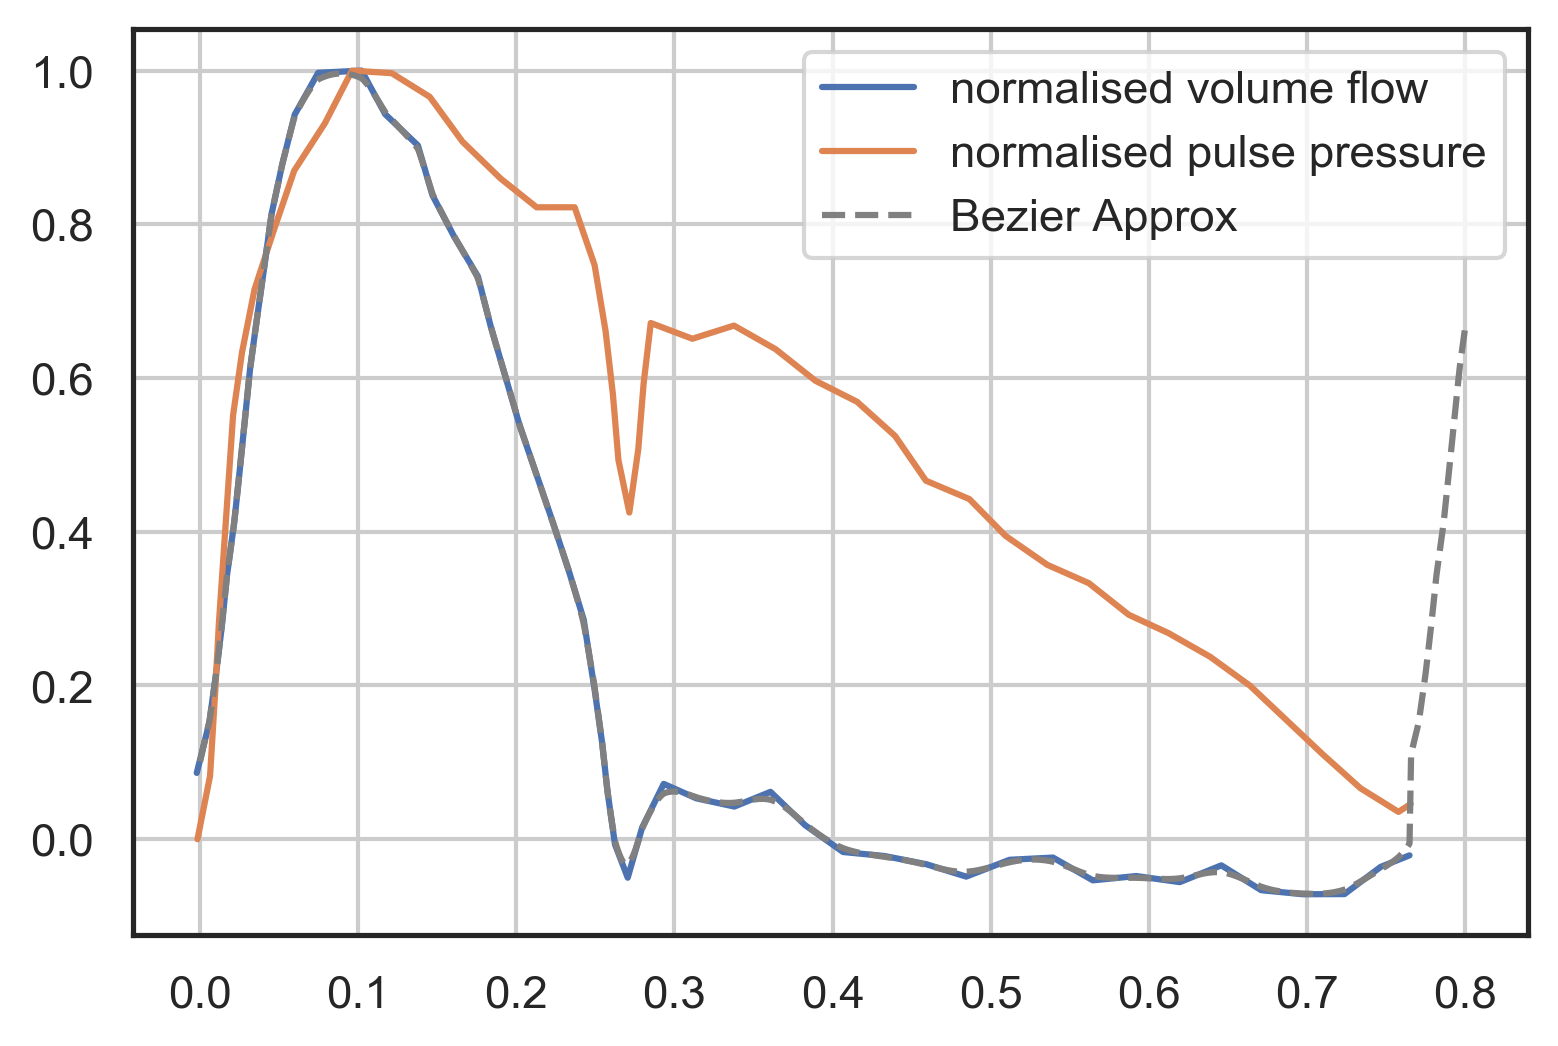

In [28]:
plt.plot(vol[0], vol[1] / np.max(vol[1]), label="normalised volume flow")

plt.plot(
    p[0],
    (p[1] - np.min(p[1])) / (np.max(p[1]) - np.min(p[1])),
    label="normalised pulse pressure",
)

t = np.linspace(0, 0.8, 800)

plt.plot(t, I_Stergio(t) / np.max(vol[1]), "--", label="Bezier Approx", color="grey")

plt.legend()
plt.grid()

The values for the windkessel models have been taken from <sup id="62eeadc764a4ca42effcde05912ef24d"><a href="#Stergiopulos1999a" title="Stergiopulos, Westerhof \&amp; Westerhof, Total Arterial Inertance as the Fourth Element of the Windkessel Model, {American Journal of Physiology-Heart and Circulatory Physiology}, v(1), H81-H88 (1999).">Stergiopulos1999a</a></sup>, table 2.



In [29]:
# Set parameters for Windkessel Model
# cite:Stergiopulos1999a Type C
Rc3 = 0.03
Rc4 = 0.045
Rp = 0.63
C3 = 5.16
C4 = 2.53
Lp = 0.0054
Ls = 0.0
# Rc3 = 0.03121307
# Rp3 = 0.63543930
# C3 =  4.54903588

time_start = 0
time_end = 10
N = (time_end - time_start) * 1000

Solve 3-element windkessel:



In [30]:
pressure3wk = wk.solve_wk(
    fun=I_Stergio,
    Rc=Rc3,
    Rp=Rp,
    C=C3,
    L=0.0,
    time_start=time_start,
    time_end=time_end,
    N=N,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

And the 4-element windkessel using the `WK5` implementation with $L_{s} = 0$:



In [31]:
pressure4wk = wk.solve_wk5(
    fun=I_Stergio,
    Rc=Rc4,
    Rp=Rp,
    C=C4,
    Lp=Lp,
    Ls=0.0,
    time_start=time_start,
    time_end=time_end,
    N=N,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

(9.1, 10)

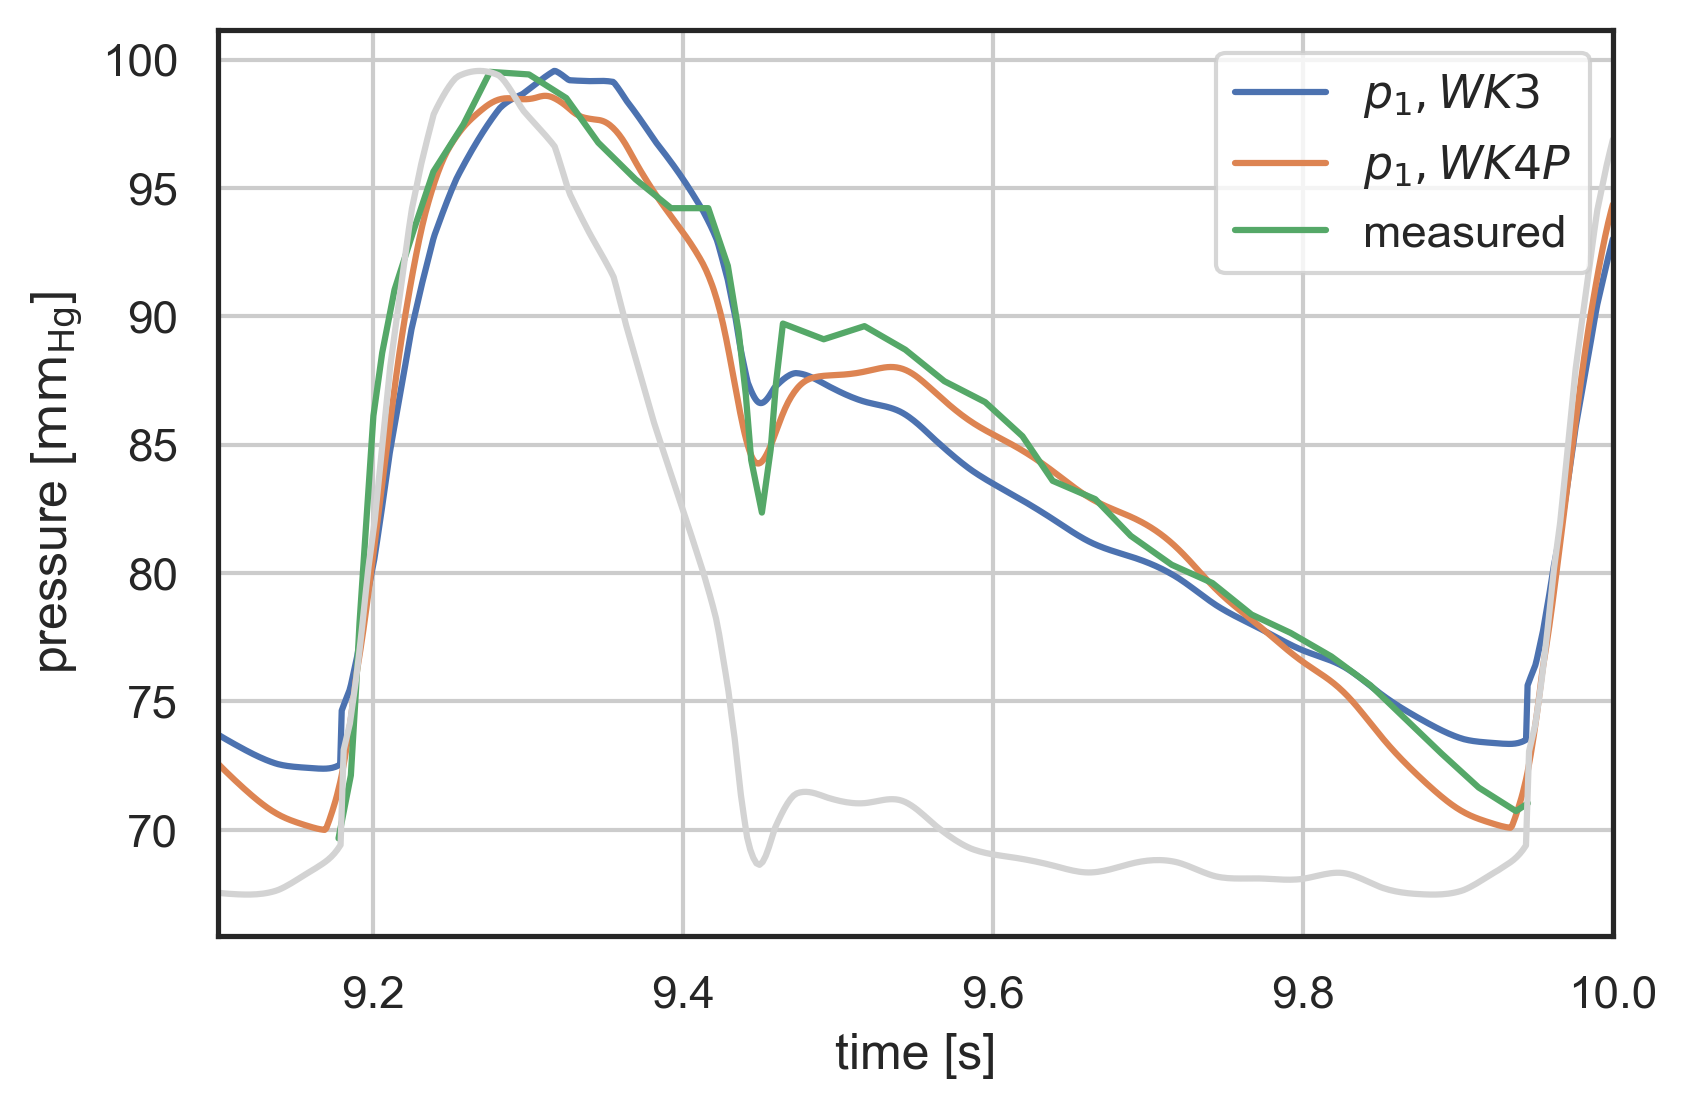

In [32]:
# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")

startN = int(0.7 * N)
# plot first and second component (index 0, 1) of array 'y'
# over array 't':
# plt.plot(pressure2wk.t[startN:], pressure2wk.y[0][startN:], label="$p_1, WK2$")
plt.plot(pressure3wk.t[startN:], pressure3wk.y[0][startN:], label="$p_1, WK3$")
# plt.plot(pressure4wks.t[startN:], pressure4wks.y[0][startN:], label="$p_1, WK4S$")
plt.plot(pressure4wk.t[startN:], pressure4wk.y[0][startN:], label="$p_1, WK4P$")
# plt.plot(
#     pressure.t[startN:],
#     pressure.y[0][startN:]
#     - R1 * I_generic(pressure.t[startN:])
#     - L * wk.ddt(I_generic, pressure.t[startN:]),
#     label="p_2 analytical",
# )

plt.plot(p[0] + 12 * np.max(vol[0]), p[1], label="measured")


t = np.linspace(8, 10, 1000)
plt.plot(
    t,
    I_Stergio(t) / np.max(I_Stergio(t))
    *(np.max(pressure3wk.y[0]) - np.min(pressure3wk.y[0][startN:]))
    + np.min(pressure3wk.y[0][startN:]),
    color="lightgrey",
)

plt.legend()
plt.grid()
plt.xlim(9.1, 10)

## Parameter optimisation



One of the common problems is finding the parameters for a windkessel model based on  measured flow rate and pressure waveforms.

This is an optimisation problem, similar to a curve fitting problem. In our case the model function is not given as a function, but as the integration problem solved above.

So let&rsquo;s see if I can estimate the parameters for the windkessel models given volume flow rate and pressure measurements.

The easiest and most common way to fit a curve is using the Levenberg-Marquardt (LM) least-spares method. However in our case this fails. Most likely because the method cannot find clear derivates, or trends, based on the initial small shifts from the initial guess. It is also notorious for only finding local minima.

There are two scipy modules that are commonly used for these optimisation fits. The simply one is `scipy.optimise`, which will be sufficient in most cases. Then there is the `lmfit` framework ([lmfit website](https://lmfit.github.io/lmfit-py)), which has a few nice feature (a `Model` and `Minimizer` class, and the definition of parameters as a *dictionary*). `lmfit` also has some additional optimization routines (despite the name, it can do a lot more than LM).

This is the output of the LM least-squares fit. The result is always only very slightly different from the initial guess. So the LM method is not suitable for our problem, because it cannot establish a clear gradient from the initial guess.

    [[Fit Statistics]]
        # fitting method   = leastsq
        # function evals   = 57
        # data points      = 45
        # variables        = 3
        chi-square         = 5737.26944
        reduced chi-square = 136.601653
        Akaike info crit   = 224.163428
        Bayesian info crit = 229.583416
    [[Variables]]
        Rc:  0.02495009 +/- 0.01126909 (45.17%) (init = 1)
        Rp:  2.00057905 +/- 7.4233e-06 (0.00%) (init = 2)
        C:   9.99369127 +/- 4.7524e-04 (0.00%) (init = 10)
    [[Correlations]] (unreported correlations are < 0.100)
        C(Rp, C)  = -0.906
        C(Rc, Rp) =  0.814
        C(Rc, C)  = -0.713

*Note: I am not an expert in optimisation methods, so will need to invest some time in this. I will also need some help from somebody with more experience in this.*



### Monte Carlo Method



An obvious method to find a global minimum on any model would be the brute force method, i.e. scanning the whole parameter space with a given step. Obviously this scales with $N^{n}$, with $N$, number of scanning points, and $n$, number of parameters, which makes the method not economic and increasingly unsuitable with increasing number of parameters. It may be a solution in cases where the initial guess is relieable and the parameter space can be limited using a-priori knowledge.

`lmfit` has the Markov Chain Monte Carlo method as one of the optimisation frameworks. This integrates [emcee](https://emcee.readthedocs.io/en/stable/) to do the scanning of the parameter space. The parameter fit using this method seems to be reliable, but it is also scaling with $ ^{n}$ and is resource-hungry, if not parameterised close to the minimum.

The following code will run approx. 50 hours on a single CPU (2.5 GHz 5th gen i7), so is not implemented as a workbook, but as a standalone script:

*Note: The script should parallelise, but doesn&rsquo;t properly. The first iterations do spawn the child processed, but after the first 100 iteration (when the method is reinitialised for the second set - showing progress), it does not respawn the child processes and continues the run on a single CPU.* 

    import numpy as np
    import scipy as sp
    import scipy.interpolate
    import scipy.optimize
    import matplotlib.pyplot as plt
    import lmfit
    
    import emcee
    import windkessel as wk
    
    # Import shared memory MP framework
    # for distributed MPI use the "Schwimmbad" implementation of "Pool"
    import multiprocessing
    
    # Initialise the MP pool (shared memory on 28cpu node)
    pool = multiprocessing.Pool(processes=28)
    
    
    # Read data
    datafile = "stergiopulos1999_fig4_typeC.csv"
    
    vol = np.genfromtxt(datafile, delimiter=",", skip_header=1, unpack=True)
    
    
    datafile = "stergiopulos1999_fig4_typeC_p.csv"
    
    p = np.genfromtxt(datafile, delimiter=",", skip_header=1, unpack=True)
    
    
    # Def volume flow waveform for windkessel model
    def I_Stergio(t):
        return wk.PWBezier(vol, t)
    
    
    # Function that will be optimised (Minimisation problem, so return residual)
    def wk_residual(pars, t, data=None, eps=None):
    
        # unpack parameters: extract .value attribute for each parameter
        # 3-element windkessel
        parvals = pars.valuesdict()
        Rc = parvals["Rc"]
        Rp = parvals["Rp"]
        C = parvals["C"]
        # for 4/5 element use these:
        # Ls = parvals["Ls"]
        # Lp = parvals["Lp"]
    
        # 3-element, change for 4/5 element
        pressure = wk.solve_wk(
        # pressure = wk.solve_wk5(
            fun=I_Stergio,
            Rc=Rc,
            Rp=Rp,
            C=C,
            # 3-element wk, use the next line:
            L = 0.0;
            # 4/5 element, uncomment the following two lines:
            # Ls=Ls,
            # Lp=Lp,
            time_start=0,
            time_end=10,
            N=10000,
            method="RK45",
            initial_cond=[0, 0],
            rtol=1e-9,
        )
    
        # return the 11th cycle for optimisation
        t = t + 10 * np.max(t)
    
        # not really needed, but nice to keep an eye on the values and learn
        # how the algorithm develops the random walk
        print("Iteration values :", Rc, Rp, C)
    
        model = sp.interpolate.interp1d(
            pressure.t, pressure.y[0], fill_value="extrapolate"
        )(t)
    
        # return values or residual
        if data is None:
            return model
        if eps is None:
            return model - data
        return (model - data) / eps
    
    # Main code starts here
    
    # Initial values
    Rc0 = 0.1
    Rp0 = 2
    C0 = 2.1
    # for 4/5 element WK use the following:
    # Ls0 = 0.02
    # Lp0 = 0.02
    
    # use times from the original scan data
    t = p[0]
    
    
    params = lmfit.Parameters()
    params.add("Rc", value=Rc0, min=0.0, max=1.0)
    params.add("Rp", value=Rp0, min=0.01, max=5.0)
    params.add("C", value=C0, min=0.0, max=10.0)
    # 4/5 wk:
    # params.add("Ls", value=Ls0, min=0.0, max=1.0)
    # params.add("Lp", value=Lp0, min=0.0001, max=1.0)
    
    
    # call the minimizer
    result = lmfit.minimize(
        wk_residual, params, args=(t, p[1]), method="emcee", workers=pool
    )
    
    # print result
    print(lmfit.fit_report(result))

The result of this run is:

    The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
    N/50 = 20;
    tau: [53.98102615 80.97150882 93.43245913]
    Iteration values : 0.031213074384297365 0.6354393031093962 4.54903588439194
    [[Fit Statistics]]
        # fitting method   = emcee
        # function evals   = 100000
        # data points      = 45
        # variables        = 3
        chi-square         = 280.230757
        reduced chi-square = 6.67216088
        Akaike info crit   = 88.3027908
        Bayesian info crit = 93.7227782
    [[Variables]]
        Rc:  0.03121307 +/- 0.00108606 (3.48%) (init = 0.1)
        Rp:  0.63543930 +/- 0.19441108 (30.59%) (init = 2)
        C:   4.54903588 +/- 0.19736334 (4.34%) (init = 2.1)
    [[Correlations]] (unreported correlations are < 0.100)
        C(Rp, C) =  0.537
        C(Rc, C) = -0.440

These values are close to the original optimisation in <sup id="62eeadc764a4ca42effcde05912ef24d"><a href="#Stergiopulos1999a" title="Stergiopulos, Westerhof \&amp; Westerhof, Total Arterial Inertance as the Fourth Element of the Windkessel Model, {American Journal of Physiology-Heart and Circulatory Physiology}, v(1), H81-H88 (1999).">Stergiopulos1999a</a></sup>: $R_{c} = 0.03, R_{p} = 0.63, C = 5.16$. The resistances are within round-off, but the capacitance is $12\%$ lower.



In [33]:
Rc = 0.03121307
Rp = 0.63543930
C = 4.54903588

pressure3fitEMCEE = wk.solve_wk(
    fun=I_Stergio,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=0.0,
    time_start=time_start,
    time_end=time_end,
    N=N,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

(9.1, 10)

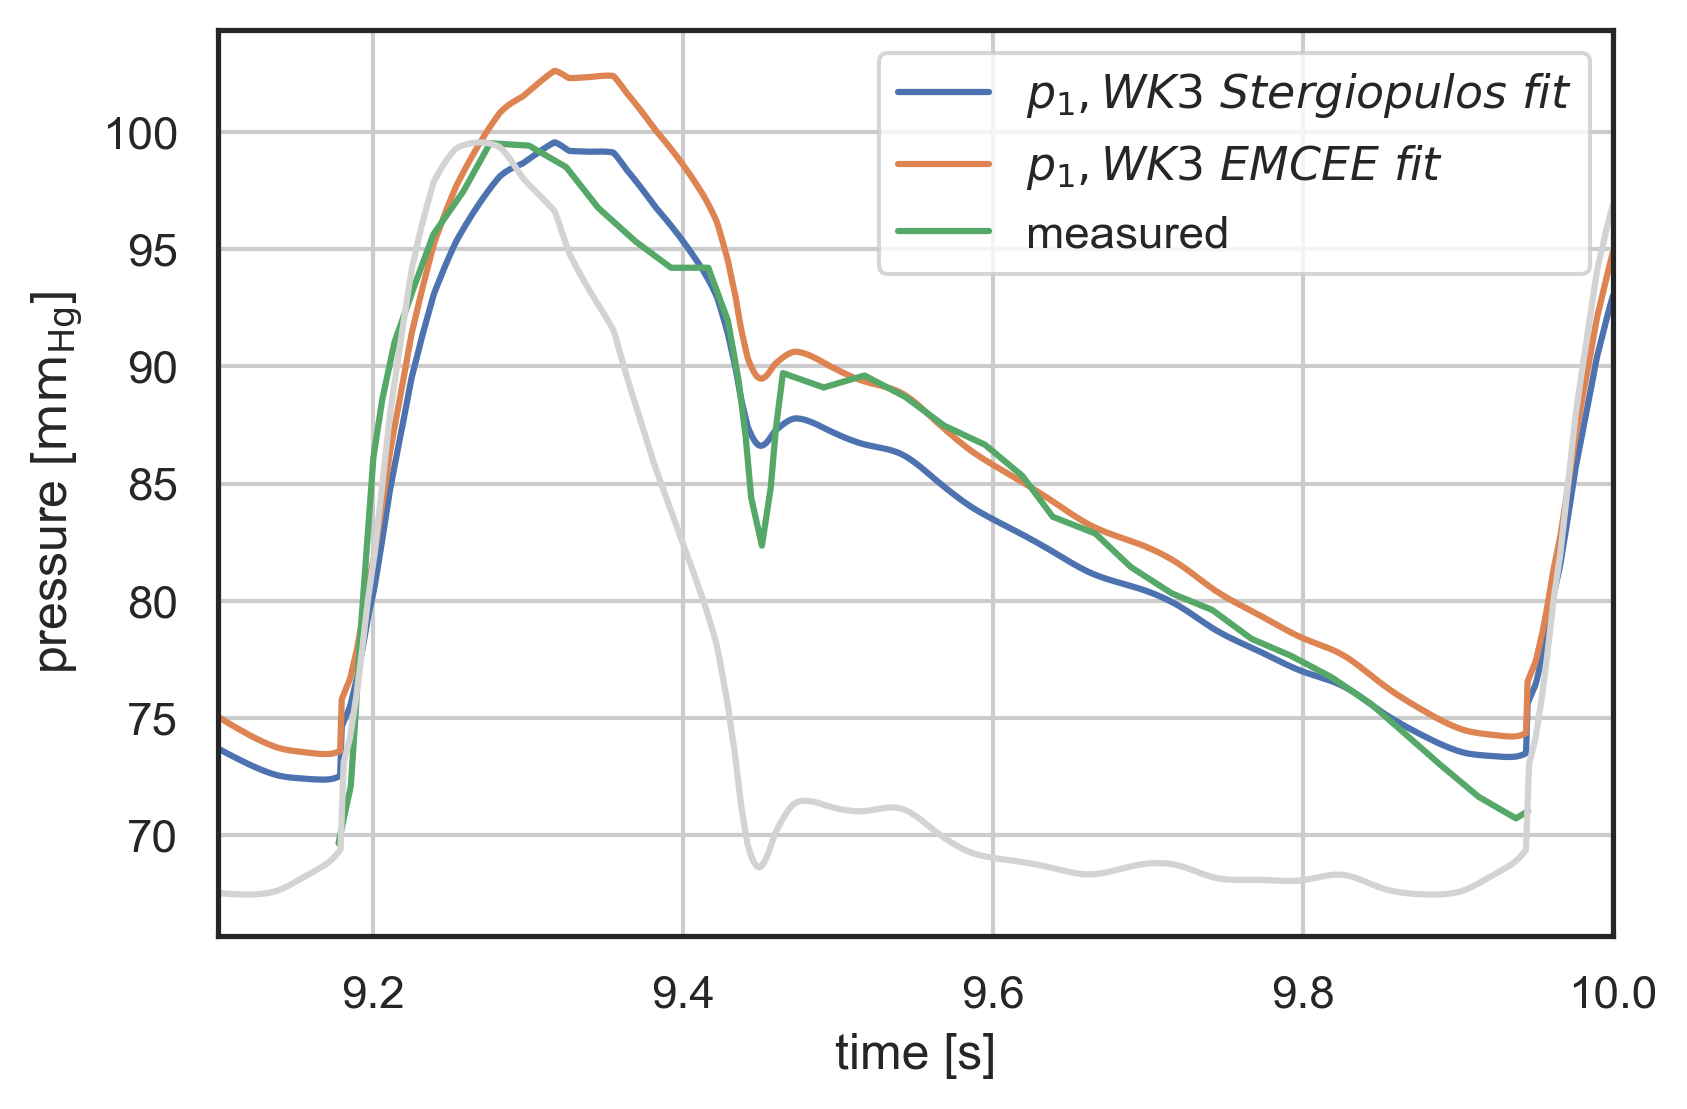

In [34]:
# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")

startN = int(0.7 * N)
# plot first and second component (index 0, 1) of array 'y'
# over array 't':
# plt.plot(pressure2wk.t[startN:], pressure2wk.y[0][startN:], label="$p_1, WK2$")
plt.plot(pressure3wk.t[startN:], pressure3wk.y[0][startN:], label="$p_1, WK3\ Stergiopulos\ fit$")
# plt.plot(pressure4wks.t[startN:], pressure4wks.y[0][startN:], label="$p_1, WK4S$")
plt.plot(pressure3fitEMCEE.t[startN:], pressure3fitEMCEE.y[0][startN:], label="$p_1, WK3\ EMCEE\ fit$")

# plt.plot(pressure4fitNM.t[startN:], pressure4fitNM.y[0][startN:], label="$p_1, WK4\ NM\ fit$")
# plt.plot(pressure5fitNM.t[startN:], pressure5fitNM.y[0][startN:], label="$p_1, WK5\ NM\ fit$")
# plt.plot(
#     pressure.t[startN:],
#     pressure.y[0][startN:]
#     - R1 * I_generic(pressure.t[startN:])
#     - L * wk.ddt(I_generic, pressure.t[startN:]),
#     label="p_2 analytical",
# )

plt.plot(p[0] + 12 * np.max(vol[0]), p[1], label="measured")


t = np.linspace(8, 10, 1000)
plt.plot(
    t,
    I_Stergio(t) / np.max(I_Stergio(t))
    *(np.max(pressure3wk.y[0]) - np.min(pressure3wk.y[0][startN:]))
    + np.min(pressure3wk.y[0][startN:]),
    color="lightgrey",
)

plt.legend()
plt.grid()
plt.xlim(9.1, 10)

*Note: This is promising and shows that the parameter optimisation is working. But there must be a better algorithm for this. Or at least a way to get the parameter scanning work in parallel.*



#### Run local minimum scan



Based on this result a localised scan in a 20% window around the values found in the first run is running. The hope is, that a two staged approach will prove to be more accurate and scale better.



#### 4/5 element windkessel optimisation



Running at the moment, estimated wallclock time for single CPU run: 520 hours



### Nelder-Mead Optimisation



Matlab&rsquo;s standard fitting tool `fminsearch` uses the [Nelder-Mead Method (NM)](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method) to optimise the  parameters. NM is a gradient free optimiser for local minima. So it depends on a good initial guess. But it is efficient and a lot quicker than the Monte Carlo method (12 minutes vs 50 hours for the 3-element optimisation).

-   3- element optimisation, runtime 12 minutes, single CPU:

    [[Fit Statistics]]
        # fitting method   = Nelder-Mead
        # function evals   = 381
        # data points      = 45
        # variables        = 3
        chi-square         = 279.735389
        reduced chi-square = 6.66036640
        Akaike info crit   = 88.2231732
        Bayesian info crit = 93.6431607
    [[Variables]]
        Rc:  0.03113800 +/- 0.00154258 (4.95%) (init = 0.1)
        Rp:  0.63460135 +/- 0.00196631 (0.31%) (init = 1)
        C:   4.54947360 +/- 0.01356166 (0.30%) (init = 2.1)
    [[Correlations]] (unreported correlations are < 0.100)
        C(Rc, Rp) = -0.353

So the Nelder-Mead optimisation arrives at the same solution than the MC method, but at a significantly lower computational cost (381 integration runs for NM, 100000 integration runs for MC).

-   4-element opimisation,  parallel inertance, runtime 75 minutes, single CPU:

    [[Fit Statistics]]
        # fitting method   = Nelder-Mead
        # function evals   = 743
        # data points      = 45
        # variables        = 4
        chi-square         = 166.525129
        reduced chi-square = 4.06158851
        Akaike info crit   = 66.8817679
        Bayesian info crit = 74.1084179
    [[Variables]]
        Rc:  0.04315254 +/- 4.4396e-04 (1.03%) (init = 0.1)
        Rp:  0.63486371 +/- 0.00142771 (0.22%) (init = 1)
        C:   2.39246377 +/- 0.01014358 (0.42%) (init = 2.1)
        Lp:  0.00536603 +/- 5.1957e-05 (0.97%) (init = 0.02)
    [[Correlations]] (unreported correlations are < 0.100)
        C(C, Lp) = -0.163
        C(Rp, C) = -0.156
        C(Rc, C) = -0.143

These values are very close to the original optimisation in <sup id="62eeadc764a4ca42effcde05912ef24d"><a href="#Stergiopulos1999a" title="Stergiopulos, Westerhof \&amp; Westerhof, Total Arterial Inertance as the Fourth Element of the Windkessel Model, {American Journal of Physiology-Heart and Circulatory Physiology}, v(1), H81-H88 (1999).">Stergiopulos1999a</a></sup>: $R_{c} = 0.043, R_{p} = 0.63, C = 2.53, L_{p} = 0.0054$. Capacitance is again estimated lower here, but the effect is less obvious in the pressure waveform:

*Note: The 4-element optimisation with serial inertance converges to the same values as the 3-element optimisation with an extremely low inertance:*

-   4-element opimisation, serial inertance, runtime 20 minutes, single CPU:

    [[Fit Statistics]]
        # fitting method   = Nelder-Mead
        # function evals   = 578
        # data points      = 45
        # variables        = 4
        chi-square         = 279.534545
        reduced chi-square = 6.81791574
        Akaike info crit   = 90.1908526
        Bayesian info crit = 97.4175026
    [[Variables]]
        Rc:  0.03112870 +/- 0.00146585 (4.71%) (init = 0.1)
        Rp:  0.63447718 +/- 7.9329e-04 (0.13%) (init = 1)
        C:   4.54515385 +/- 0.00544312 (0.12%) (init = 2.1)
        Ls:  7.6397e-10 +/- 2.8473e-07 (37269.54%) (init = 0.02)
    [[Correlations]] (unreported correlations are < 0.100)
        C(Rc, Rp) = -0.101

-   5-element optimisation, runtime 90 minutes, single CPU:

    [[Fit Statistics]]
        # fitting method   = Nelder-Mead
        # function evals   = 916
        # data points      = 45
        # variables        = 5
        chi-square         = 166.517988
        reduced chi-square = 4.16294969
        Akaike info crit   = 68.8798381
        Bayesian info crit = 77.9131506
    [[Variables]]
        Rc:  0.04306403 +/- 4.1288e-04 (0.96%) (init = 0.1)
        Rp:  0.63485549 +/- 0.00129126 (0.20%) (init = 1)
        C:   2.39128343 +/- 0.00666945 (0.28%) (init = 1)
        Ls:  1.5358e-05 +/- 2.6904e-06 (17.52%) (init = 0.02)
        Lp:  0.00535077 +/- 5.4970e-05 (1.03%) (init = 0.02)
    [[Correlations]] (unreported correlations are < 0.100)
        C(C, Lp)  =  0.412
        C(Ls, Lp) =  0.308



#### Comparison of 3-, 4-, and 5-element windkessel models with Nelder-Mead optimised parameters.



In [35]:
Rc = 0.03121307
Rp = 0.63543930
C = 4.54903588

pressure3fitNM = wk.solve_wk(
    fun=I_Stergio,
    Rc=Rc,
    Rp=Rp,
    C=C,
    L=0.0,
    time_start=time_start,
    time_end=time_end,
    N=N,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

In [36]:
Rc = 0.04315254
Rp = 0.63486371
C = 2.39246377
Lp = 0.00536603

pressure4fitNM = wk.solve_wk5(
    fun=I_Stergio,
    Rc=Rc,
    Rp=Rp,
    C=C,
    Lp=Lp,
    Ls=0.0,
    time_start=time_start,
    time_end=time_end,
    N=N,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

In [37]:
Rc =  0.04306403
Rp =  0.63485549
C =  2.39128343
Ls =  1.5358e-05
Lp =  0.00535077

pressure5fitNM = wk.solve_wk5(
    fun=I_Stergio,
    Rc=Rc,
    Rp=Rp,
    C=C,
    Ls=Ls,
    Lp=Lp,
    time_start=time_start,
    time_end=time_end,
    N=N,
    method="RK45",
    initial_cond=[0, 0],
    rtol=1e-9,
)

(9.1, 10)

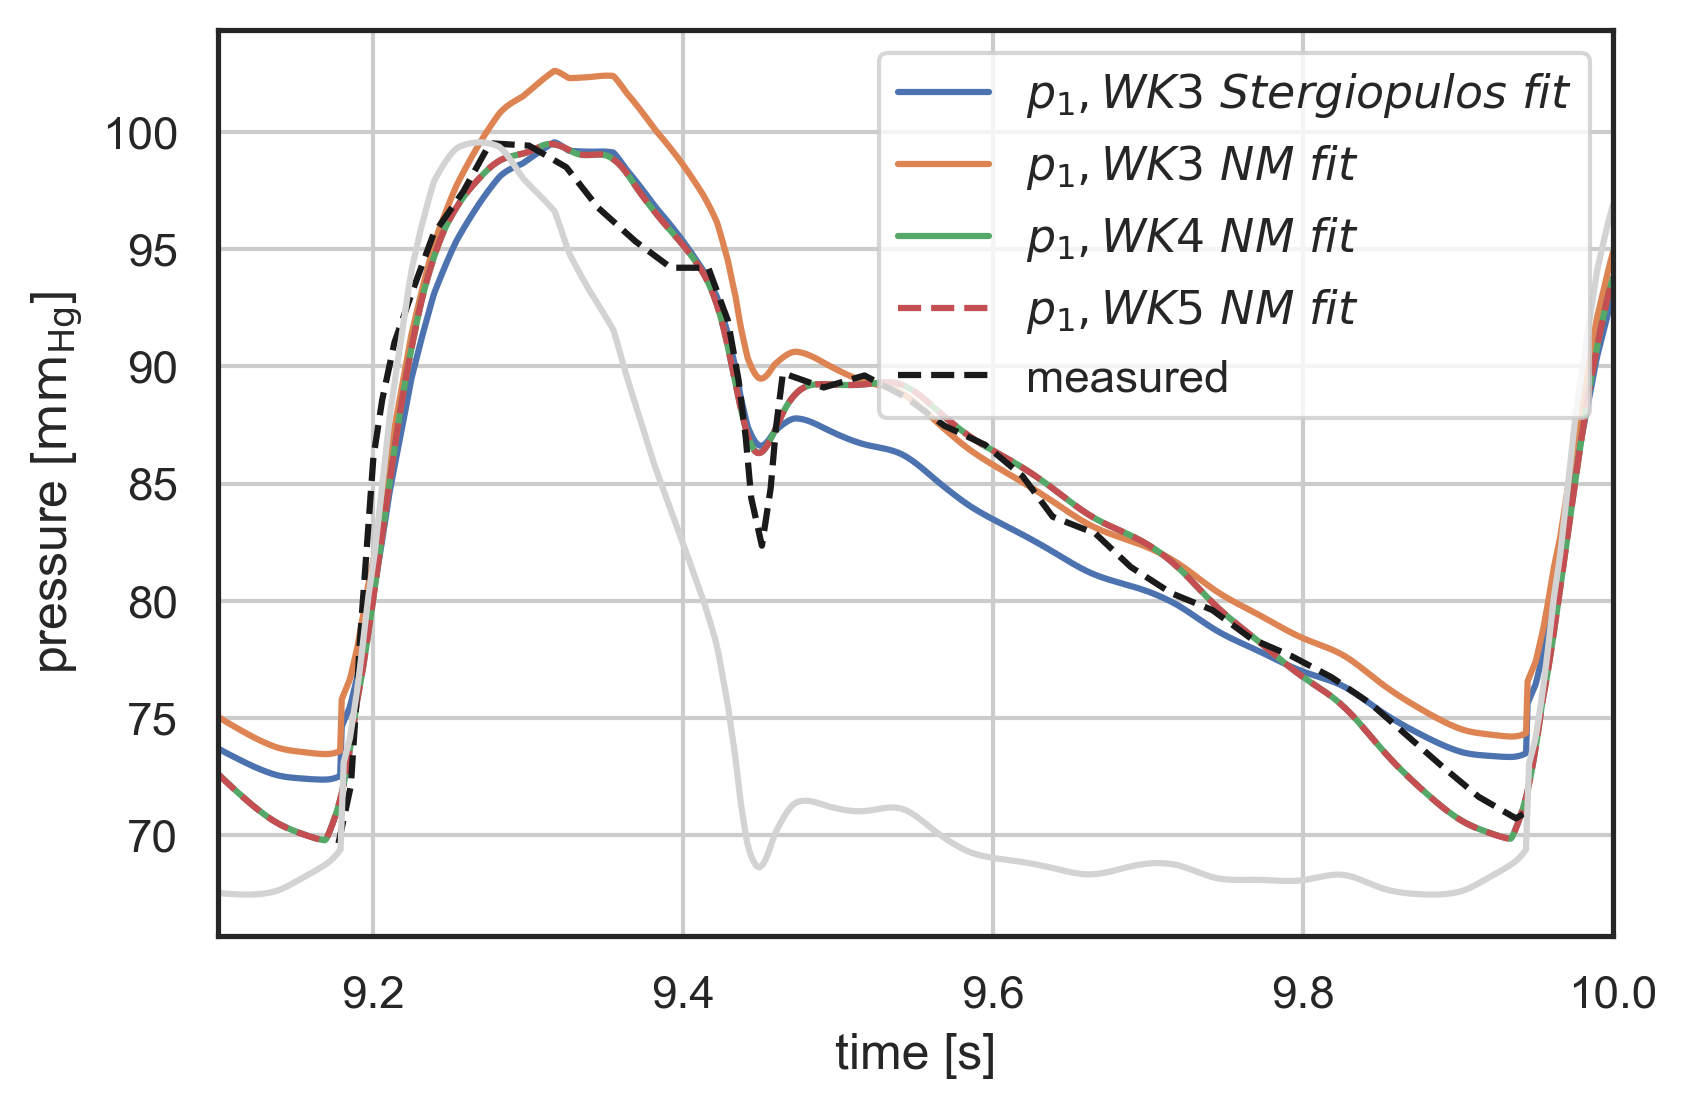

In [38]:
# plot curves
plt.xlabel("time [s]")
plt.ylabel("pressure [$\\mathrm{mm_{Hg}}$]")

startN = int(0.7 * N)
# plot first and second component (index 0, 1) of array 'y'
# over array 't':
# plt.plot(pressure2wk.t[startN:], pressure2wk.y[0][startN:], label="$p_1, WK2$")
plt.plot(
    pressure3wk.t[startN:],
    pressure3wk.y[0][startN:],
    label="$p_1, WK3\ Stergiopulos\ fit$",
)
# plt.plot(pressure4wks.t[startN:], pressure4wks.y[0][startN:], label="$p_1, WK4S$")
# plt.plot(pressure3fitEMCEE.t[startN:], pressure3fitEMCEE.y[0][startN:], label="$p_1, WK3\ EMCEE\ fit$")
plt.plot(
    pressure3fitNM.t[startN:], pressure3fitNM.y[0][startN:], label="$p_1, WK3\ NM\ fit$"
)
plt.plot(
    pressure4fitNM.t[startN:], pressure4fitNM.y[0][startN:], label="$p_1, WK4\ NM\ fit$"
)

plt.plot(
    pressure5fitNM.t[startN:], pressure5fitNM.y[0][startN:], "--", label="$p_1, WK5\ NM\ fit$"
)
# plt.plot(
#     pressure.t[startN:],
#     pressure.y[0][startN:]
#     - R1 * I_generic(pressure.t[startN:])
#     - L * wk.ddt(I_generic, pressure.t[startN:]),
#     label="p_2 analytical",
# )

plt.plot(p[0] + 12 * np.max(vol[0]), p[1], "k--", label="measured")


t = np.linspace(8, 10, 1000)
plt.plot(
    t,
    I_Stergio(t)
    / np.max(I_Stergio(t))
    * (np.max(pressure3wk.y[0]) - np.min(pressure3wk.y[0][startN:]))
    + np.min(pressure3wk.y[0][startN:]),
    color="lightgrey",
)

plt.legend()
plt.grid()
plt.xlim(9.1, 10)

*Note: The 3-element windkessel optimisation does not find the same capacitance as in <sup id="62eeadc764a4ca42effcde05912ef24d"><a href="#Stergiopulos1999a" title="Stergiopulos, Westerhof \&amp; Westerhof, Total Arterial Inertance as the Fourth Element of the Windkessel Model, {American Journal of Physiology-Heart and Circulatory Physiology}, v(1), H81-H88 (1999).">Stergiopulos1999a</a></sup>. The same occurs in the 4-element serial model. This needs further research.*

*Assumption: The 3-element windkessel is either too high during systole or too low during diastole. Since diastole is longer, its influence on the overall residual that is minimised is higher.*



## Bibliography




# Table of Contents




[library.bib](library.bib)

